# **Unsupervised Domain Adaptation (UDA)**

<p align = "justify">This notebook contains the UDA project for the Deep Learning course developed by:

| <font size="3">Name | <font size="3">Surname | <font size="3">ID number | <font size="3">Github |
|------|---------|-----------|--------|
|<center><font size="3"> Carlo | <font size="3"><center>Marotta| <font size="3"><center>231590 | <font size="3"><center><a href="https://github.com/akaGallo/" target="_blank"><i>akaGallo</i></a>|
| <font size="3"><center>Pierluca | <font size="3"><center>Faccin | <font size="3"><center>233424 | <font size="3"><center><a href="https://github.com/pierlucafaccin/" target="_blank">pierlucafaccin</a> |

--- 
**Unsupervised Domain Adaptation**: learning framework to transfer knowledge learned from source domains with a large number of annotated training examples to target domains with unlabeled data only. 

In particular, we are going to consider a **labelled** source dataset $S = \{X_i^S, y_i^S\}_{i=1}^{N_S}$,  and an **unlabelled** target dataset $Τ = \{X_i^T\}_{i=1}^{N_s}$, where $X_i \in \mathcal{X}$ and $y \in \mathcal{Y}$, $\mathcal{Y} = \{1, 2, ..., K\}$ ($K$ denotes the number of object categories).

The goal is to learn a function $F_{\theta}: \mathcal{X} \rightarrow \mathcal{Y}$  with parameters $\theta$ that maps an input image $X$ to a class label $y$ and perform well on target data. In other words, we are required to 
* train our model **supervisedly** on the source domain, i.e. having access to the images as well as the object labels;
* train our model **unsupervisedly** on the training set of the target domain, i.e. having access to the images, but not to the labels;
* evaluate our model on the test set of your target domain.
---
**Objective**: use an Unsupervised Domain Adpatation technique of choice in order to improve performances with respect to a baseline.

---

#### **Import libraries**

In [ ]:
from google.colab import drive

import torch, torchvision, math, types, random, copy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from enum import Enum
import torch.nn as nn
from torch import Tensor
from os.path import join
import torch.optim as optim
from shutil import copytree
from typing import Tuple, List
from os import makedirs, listdir
from torch.autograd import Function
from matplotlib.pyplot import figure
from torchvision import transforms, models 
from sklearn.metrics import confusion_matrix
from torchvision.datasets import ImageFolder  
from sklearn.metrics import classification_report
from torch.utils.data import Subset, Dataset, DataLoader

#### **Mount drive**

In [ ]:
# Mount google drive to access the dataset stored in the drive
drive.mount('/content/gdrive', force_remount=True)

#### **Set arguments**

In [ ]:
# Set the device to use
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directory to the full dataset
DIR_PATH = "gdrive/My\ Drive/datasets/"

# Directory to the folders of our datasets
PRODUCT_PATH = "gdrive/My Drive/datasets/adaptiope_small/product_images/"
REAL_PATH = "gdrive/My Drive/datasets/adaptiope_small/real_life/"

# Classes of our dataset
CLASSES = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller", "glasses",
           "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen",
           "purse", "stand mixer", "stroller"]

# Basic parameters
NUM_CLASSES = 20
NUM_EPOCHS = 15

# Batch sizes for training and test phases
BATCH_SIZE_128 = 128
BATCH_SIZE_64 = 64
BATCH_SIZE_32 = 32
BATCH_SIZE_16 = 16

# Mean and standard deviation values for trasforming images
MEANS, STDS = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

# Parameters for optimizer
LEARNING_RATE = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-6

# Initialize lists to store predicted and true labels (for confusion matrix and classification report)
pred_labels = []
true_labels = []

### **Dataset**

As a UDA benchmark, in this assignment we will be using the [Adaptiope](https://paperswithcode.com/paper/adaptiope-a-modern-benchmark-for-unsupervised/) object recognition dataset which comprises images from 3 distinct domains, referring to <u>*synthetic*</u>, <u>*product*</u> and <u>*real world*</u> data and 123 classes.
A visual example is provided:

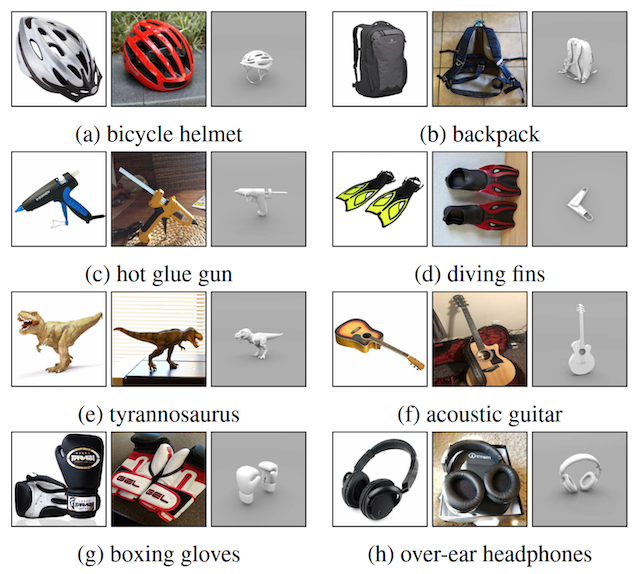

---

#### **Import zip file**

In [ ]:
!mkdir dataset                           # Create a directory named "dataset"
!cp {DIR_PATH}"/Adaptiope.zip" dataset/  # Copy the Adaptiope.zip file from the DIR_PATH to the "dataset" directory
!ls dataset                              # List the contents of the "dataset" directory

!unzip {DIR_PATH}"/Adaptiope.zip"        # Unzip the Adaptiope.zip file in the DIR_PATH to extract the contents

#### **Define datasets**
For the sake of this assignment, we are going to exctract a subset of Adaptiope dataset consisting on 20 randomly chosen categories from the <u>*product*</u> and <u>*real world*</u> domains. The chosen categories are:

|<font size="3">Classes|
|-------|
| <font size="2"><center> *over-ear eadphones* |
| <font size="2"><center> *game controller* |
| <font size="2"><center> *network switch* |
| <font size="2"><center> *stand mixer* |
| <font size="2"><center> *file cabinet* |
| <font size="2"><center> *letter tray* |
| <font size="2"><center> *ice skates* |
| <font size="2"><center> *helicopter* | 
| <font size="2"><center> *backpack* | 
| <font size="2"><center> *bookcase* | 
| <font size="2"><center> *car jack* |
| <font size="2"><center> *flat iron*|
| <font size="2"><center> *stroller* |
| <font size="2"><center> *glasses* |  
| <font size="2"><center> *monitor* |
| <font size="2"><center> *crown* |
| <font size="2"><center> *purse* |
| <font size="2"><center> *comb* |
| <font size="2"><center> *mug* | 
| <font size="2"><center> *pen* |

In [ ]:
# Remove the existing directory "adaptiope_small" and create a new one
!rm -rf adaptiope_small
!mkdir adaptiope_small

# Iterate over the source and target directories
for d, td in zip(["Adaptiope/product_images", "Adaptiope/real_life"], ["adaptiope_small/product_images", "adaptiope_small/real_life"]):
    makedirs(td)             # Make new directory in the target directory
    for c in tqdm(CLASSES):  # Iterate over the classes and copy the corresponding directory
        c_path = join(d, c)
        c_target = join(td, c)
        copytree(c_path, c_target)

In [ ]:
!cp -r adaptiope_small {DIR_PATH}           # Copy the "adaptiope_small" directory to the DIR_PATH
!mkdir -p dataset                           # Create a directory named "dataset" if it does not exist
!cp -r {DIR_PATH}"adaptiope_small" dataset  # Copy the "adaptiope_small" directory from the DIR_PATH to the "dataset" directory

#### **Define data preprocessing**

◇ **`transformation`** is created using `transforms.Compose()` from the `torchvision.transforms` module in order to transform image data by taking a list of transformation objects:
* `transforms.Resize(256)` resizes the shorter side of the image to a length of 256 pixels;
* `transforms.CenterCrop(224)` crops a square patch of the image with a size of 224x224 pixels from the center of the image;
* `transforms.ToTensor()` converts the image from a PIL (Python Imaging Library) image to a tensor, a multi-dimensional array of numbers that can be processed by a machine learning model;
* `transforms.Normalize(MEANS, STDS)` normalizes the tensor by subtracting the mean and dividing by the standard deviation of the tensor, as specified by the MEANS and STDS variables

`product_dataset` and `real_dataset` match two datasets from the specified paths, `PRODUCT_PATH` and `REAL_PATH` respectively, using the `torchvision.datasets.ImageFolder` function, also defining the `transform` object that should be applied to each image in the dataset.

In [ ]:
# Define transforms for training and test phase
transformation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEANS, STDS)
])

# Load the data from the specified paths
product_dataset = torchvision.datasets.ImageFolder(root = PRODUCT_PATH, transform = transformation) 
real_dataset = torchvision.datasets.ImageFolder(root = REAL_PATH, transform = transformation) 

# Check sizes of the two datasets and class names for each dataset
print('Product Images Dataset: {}'.format(len(product_dataset)))
print('Real Life Dataset: {}'.format(len(real_dataset)))

print('Classes:', product_dataset.classes)
print('Classes:', real_dataset.classes)

Product Images Dataset: 2000
Real Life Dataset: 2000
Classes: ['backpack', 'bookcase', 'car jack', 'comb', 'crown', 'file cabinet', 'flat iron', 'game controller', 'glasses', 'helicopter', 'ice skates', 'letter tray', 'monitor', 'mug', 'network switch', 'over-ear headphones', 'pen', 'purse', 'stand mixer', 'stroller']
Classes: ['backpack', 'bookcase', 'car jack', 'comb', 'crown', 'file cabinet', 'flat iron', 'game controller', 'glasses', 'helicopter', 'ice skates', 'letter tray', 'monitor', 'mug', 'network switch', 'over-ear headphones', 'pen', 'purse', 'stand mixer', 'stroller']


#### **Define data extraction**

As pointed out in the assignment guidelines, we subdivide both the *product* and *real world* domains using `torch.utils.data.random_split` with the following ratio (validation set is not requested in this project):

- **80%** of samples for **train**
- **20%** of samples for **test**

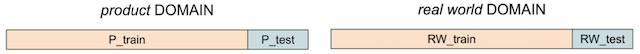

---

<p align = "justify"> ◇ <code><tt><b>get_data</b></code></tt>: determines which of the two datasets (<code><tt>product_dataset</code></tt> or <code><tt>real_dataset</code></tt>) is the source and which is the target based on the values of the <code><tt>source_path</code></tt> and <code><tt>target_path</code></tt> arguments based on the direction either <i>product → real world</i> or <i>real world → product</i>. It then splits the source and target datasets into training and testing sets using the <code><tt>test_split</code></tt> argument according to the assignment guidelines, and finally it creates <code><tt>DataLoader</code></tt> objects for the train and test sets of the source and target datasets with the corresponding batch sizes.

In [ ]:
def get_data(train_batch_size, test_batch_size, source_path, target_path, test_split = 0.2):

    if (source_path == PRODUCT_PATH):   # Case product -> real world
        source_dataset = product_dataset
        target_dataset = real_dataset
    else:                               # Case real world -> product
        source_dataset = real_dataset 
        target_dataset = product_dataset
    
    # Split the datasets into train and test sets    
    test_source_size, test_target_size = int(test_split * len(source_dataset)), int(test_split * len(target_dataset))
    train_source_size, train_target_size = len(source_dataset) - test_source_size, len(target_dataset) - test_target_size

    # Create datasets for train and test phases
    train_source_dataset, test_source_dataset = torch.utils.data.random_split(source_dataset, [train_source_size, test_source_size])
    train_target_dataset, test_target_dataset = torch.utils.data.random_split(target_dataset, [train_target_size, test_target_size])
    
    # Create the DataLoader objects
    train_source_loader = DataLoader(train_source_dataset, batch_size = train_batch_size, shuffle = True, drop_last = True)
    train_target_loader = DataLoader(train_target_dataset, batch_size = train_batch_size, shuffle = True, drop_last = True)
    
    test_source_loader = DataLoader(test_source_dataset, batch_size = test_batch_size, shuffle = True, drop_last = True)
    test_target_loader = DataLoader(test_target_dataset, batch_size = test_batch_size, shuffle = True, drop_last = True)

    return train_source_loader, test_source_loader, train_target_loader, test_target_loader

#### **Define data visualization**
<p align = "justify"> Data visualization is an important tool for understanding and interpreting data that allows us to see patterns and trends in our data, and to identify relationships between different variables. Additionally, data visualization can help us to identify outliers or anomalies in our data, and to see how our data is distributed. Overall, it is a valuable tool for exploring, understanding, and communicating data, and can be an important part of the data analysis process.

---
<p align = "justify"> ◇ <code><tt><b>show_images</b></code></tt>: is defined to display a grid of images from two image datasets: <code><tt>product_dataset</code></tt> and <code><tt>real_dataset</code></tt>. The datasets are first split into train and test sets using a given test split ratio (which is set to 0.2 by default). Then, for each of the four resulting datasets, the function randomly selects 5 images and plots them in a grid. The titles of the subplots are set to the corresponding dataset name, and the label of each image is used to set the title of each image in the grid.

In [ ]:
def show_images(test_split = 0.2):

    # Define transforms for product and real life datasets
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()])

    # Load the data from the specified paths
    product_dataset = torchvision.datasets.ImageFolder(root = PRODUCT_PATH, transform = transformation) 
    real_dataset = torchvision.datasets.ImageFolder(root = REAL_PATH, transform = transformation) 

    # Split the datasets into train and test sets
    train_product_size = int((1 - test_split) * len(product_dataset))
    test_product_size = len(product_dataset) - train_product_size
    train_real_size = int((1 - test_split) * len(real_dataset))
    test_real_size = len(real_dataset) - train_real_size

    # Create datasets for train and test phases
    train_product_dataset, test_product_dataset = torch.utils.data.random_split(product_dataset, [train_product_size, test_product_size])
    train_real_dataset, test_real_dataset = torch.utils.data.random_split(real_dataset, [train_real_size, test_real_size])

    # Create a list of datasets
    datasets = [train_product_dataset, test_product_dataset, train_real_dataset, test_real_dataset]

    # Set the titles for each subplot
    titles = ["PRODUCT -- TRAIN (80%)", "PRODUCT -- TEST (20%)", "REAL LIFE -- TRAIN (80%)", "REAL LIFE -- TEST (20%)"]

    # Set the figure size and grid layout
    fig, axes = plt.subplots(nrows = 4, ncols = 5, figsize = (16, 12), dpi = 70)

    # Iterate over the datasets and their corresponding indexes
    for i, dataset in enumerate(datasets):
        for j in range(5):
            ax = axes[i][j]
            index = random.randint(0, len(dataset)-1)   # Get a random index from the dataset
            img, label = dataset[index]                 # Get the image and label from the dataset using the random index
            folder_name = [key for key, value in dataset.dataset.class_to_idx.items() if value == label][0] # Get the folder name corresponding to the label
            ax.imshow(img.permute(1, 2, 0))             # Display the image on the axis
            ax.axis('off')
            # Set the title of the axis            
            if j == 2:
              ax.set_title(f"{titles[i]}\n\n{[folder_name]}\n")
            else:
              ax.set_title(f"{[folder_name]}\n")

    # Show the plot
    plt.subplots_adjust(wspace = 0.35, hspace = 0.8, top = 0.9, bottom = 0.1, left = 0.1, right = 0.9)
    plt.show()

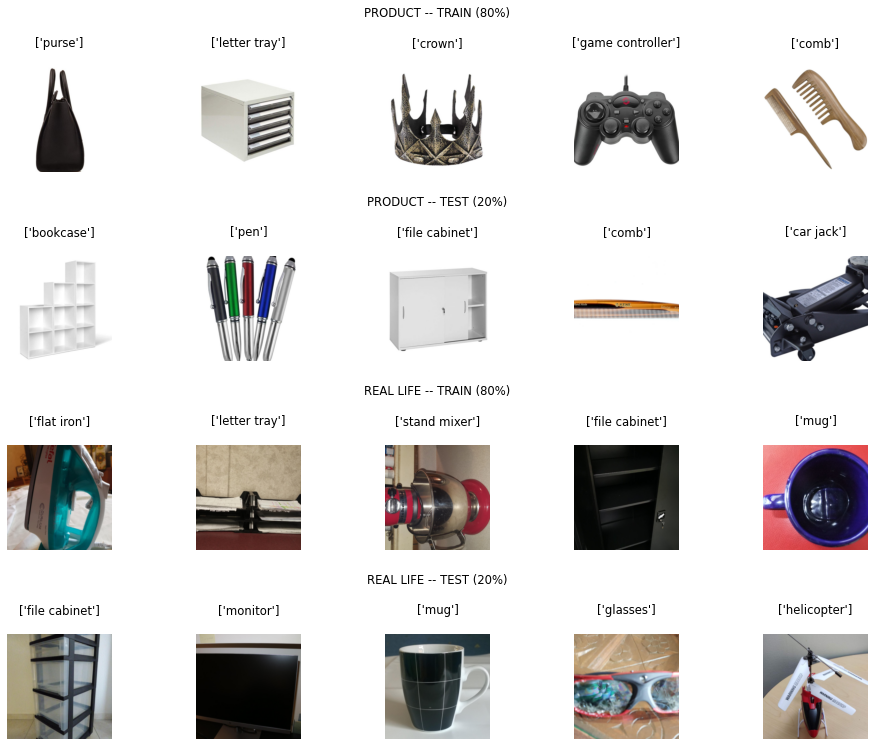

In [ ]:
show_images()

#### **Define frameworks**

<p align = "justify"> In this project we are required to consider 3 different frameworks (<u>baseline</u>, <u>upperbound</u>, and <u>unsupervised domain adaptation</u>), each of which must be characterized by <b>specific dataloaders for the training and testing phases</b> (the detailed description is provided in the introduction of each framework), also depending on the direction <i>product ⇔ real life</i>.

---

◇ **`FrameworkType`** class is used to define a set of enumeration members that represent different frameworks that can be used in the code: <u>**BASELINE**</u>, <u>**UPPERBOUND**</u> and <u>**UDA**</u>.

In [ ]:
class FrameworkType(Enum):
    BASELINE = 1
    UPPERBOUND = 2
    UDA = 3

#### **Define dataloaders**

<p align = "justify"> ◇ <code><tt><b>SourceTargetUDA</b></code></tt>: this class is initialized with two dataloaders, one for the source domain and one for the target domain. The <code><tt>__iter__</code></tt> method initializes two iterators for these dataloaders, and the <code><tt>__next__</code></tt> method returns a batch of data from these iterators. If either of these iterators reach the end of their data, they are reset and the process starts over again. The returned data consists of a batch of <b>inputs and labels</b> from the <b>source domain</b> and a batch of <b>inputs</b> from the <b>target domain</b>, while the labels for the target domain are not used. This type of dataloader is typically used in a domain adaptation setting, where the goal is to train a model on a labeled dataset from the source domain and apply it to the target domain, which has no labels.

<p align = "justify"> ◇ <code><tt><b>get_dataloaders</b></code></tt>: this function returns a pair of train and test dataloaders based on the frameworkType argument:
<ul>
  <li>if <i>frameworkType</i> is <i>BASELINE</i>, the model will be trained on the source domain and tested on the target domain;</li>
  <li>if <i>frameworkType</i> is <i>UPPERBOUND</i>, the model will be trained and tested on the target domain;</li>
  <li>if <i>frameworkType</i> is <i>UDA</i>, the model will be trained on a combination of the source and target domains and tested on the target domain.</li>
</li>
</ul>

In [ ]:
class SourceTargetUDA:
    def __init__(self, source_dataloader, target_dataloader):
        self.source_dataloader = source_dataloader
        self.target_dataloader = target_dataloader
        self.source_iter = iter(self.source_dataloader)
        self.target_iter = iter(self.target_dataloader)

    def __iter__(self):
        return self

    def __next__(self):
        source_inputs, source_targets = next(self.source_iter)
        try:
            target_inputs, _ = next(self.target_iter)
        except:
            self.target_iter = iter(self.target_dataloader)
            target_inputs, _ = next(self.target_iter)
        return source_inputs, source_targets, target_inputs


def get_dataloaders(framework_type, train_source_loader, test_source_loader, train_target_loader, test_target_loader):

    if framework_type == FrameworkType.BASELINE:
        return train_source_loader, test_target_loader

    elif framework_type == FrameworkType.UPPERBOUND:
        return train_target_loader, test_target_loader

    elif framework_type == FrameworkType.UDA:
        return SourceTargetUDA(train_source_loader, train_target_loader), test_target_loader
    
    else:
        raise ValueError("Invalid framework type")

### **Define graphs**

<p align = "justify"> We decided to plot graphs for visualizing how well the model is performing.
In general, validation curves, classification reports, and confusion matrices are useful tools for evaluating the performance of a machine learning model and understanding how well it is making predictions. They can help us identify problems with the model and suggest ways to improve its performance.

---

<p align = "justify"> ◇ <code><tt><b>validation_curve</b></code></tt>: can be used to understand how the performance of the models (Baseline, Upperbound, Deep CORAL, DANN, and DSN) changes. Indeed, showing the comparison of test losses and of test accuracies among the various models, these graphs can be useful for understanding how each model is doing on the test data with respect to the others. The first subplot shows the test loss values for our five different models, while the second subplot shows the test accuracy values for the same models. The correct plots are displayed according to the source path passed as parameter depending on the direction <i>product ⇔ real life</i>.




<p align = "justify">◇ <code><tt><b>confusion_matrix</b></code></tt>: is a table that shows the number of true positive, true negative, false positive, and false negative predictions made by the model. This tool can help us understand how well the model is performing and where it may be making mistakes.

<p align = "justify">◇ <code><tt><b>classification_report</b></code></tt>:
gives us a summary of the model's performance, including the precision, recall, and F1 score for each class.

In [ ]:
def get_validation_curve(source_path):

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (21, 16))

    # Set the title based on the source path
    if (source_path == PRODUCT_PATH):
        fig.text(x=0.43, y=0.91, s="PRODUCT → REAL WORLD", fontsize=20, weight='bold', transform=fig.transFigure)

        # Plot the train and test loss on the first subplot
        ax1.plot(Baseline_P_RW_test_loss,'--o', color='red')
        ax1.plot(Upperbound_P_RW_test_loss,'--o', color='goldenrod')
        ax1.plot(CORAL_P_RW_test_loss,'-o', color='limegreen')
        ax1.plot(DANN_P_RW_test_loss,'-o', color='deepskyblue')
        ax1.plot(DSN_P_RW_test_loss,'-o', color='blue')

        ax1.legend(['Baseline', 'Upperbound', 'Deep CORAL', 'DANN', 'DSN'])
        ax1.set_title('Test loss', fontsize = 15)

        # Plot the train and test accuracy on the second subplot
        ax2.plot(Baseline_P_RW_test_accuracy,'--o', color='red')
        ax2.plot(Upperbound_P_RW_test_accuracy,'--o', color='goldenrod')
        ax2.plot(CORAL_P_RW_test_accuracy,'-o', color='limegreen')
        ax2.plot(DANN_P_RW_test_accuracy,'-o', color='deepskyblue')
        ax2.plot(DSN_P_RW_test_accuracy,'-o', color='blue')

        ax2.legend(['Baseline', 'Upperbound', 'Deep CORAL', 'DANN', 'DSN'])
        ax2.set_title('Test accuracy', fontsize = 15)

    else:
        fig.text(x=0.40, y=0.91, s="REAL WORLD → PRODUCT", fontsize=20, weight='bold', transform=fig.transFigure)

        # Plot the train and test loss on the first subplot
        ax1.plot(Baseline_RW_P_test_loss,'--o', color='red')
        ax1.plot(Upperbound_RW_P_test_loss,'--o', color='goldenrod')
        ax1.plot(CORAL_RW_P_test_loss,'-o', color='limegreen')
        ax1.plot(DANN_RW_P_test_loss,'-o', color='deepskyblue')
        ax1.plot(DSN_RW_P_test_loss,'-o', color='blue')

        ax1.legend(['Baseline', 'Upperbound', 'Deep CORAL', 'DANN', 'DSN'])
        ax1.set_title('Test loss', fontsize = 15)

        # Plot the train and test accuracy on the second subplot
        ax2.plot(Baseline_RW_P_test_accuracy,'--o', color='red')
        ax2.plot(Upperbound_RW_P_test_accuracy,'--o', color='goldenrod')
        ax2.plot(CORAL_RW_P_test_accuracy,'-o', color='limegreen')
        ax2.plot(DANN_RW_P_test_accuracy,'-o', color='deepskyblue')
        ax2.plot(DSN_RW_P_test_accuracy,'-o', color='blue')

        ax2.legend(['Baseline', 'Upperbound', 'Deep CORAL', 'DANN', 'DSN'])
        ax2.set_title('Test accuracy', fontsize = 15)


def get_confusion_matrix():

    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    
    # Create a figure, a subplot and a heatmap of the confusion matrix
    fig = plt.figure(figsize = (12, 10))
    ax = plt.subplot()
    sns.heatmap(cm, annot = True, ax = ax, fmt = 'g');
    
    # Set x-axis label and tick labels
    ax.set_xlabel('Predicted', fontsize = 15)
    ax.xaxis.set_ticklabels(CLASSES, fontsize = 13)
    plt.xticks(rotation = 90)

    # Set y-axis label and tick labels
    ax.set_ylabel('True', fontsize = 15)
    ax.yaxis.set_ticklabels(CLASSES, fontsize = 13)
    plt.yticks(rotation = 0)

    plt.show()


def get_classification_report():

    # Generate a classification report
    report = classification_report(true_labels, pred_labels, target_names = CLASSES, output_dict = True)

    # Create a dataframe from the report
    df = pd.DataFrame(report).transpose()

    # Display the report
    display(df)

### **Test procedure**
<p align = "justify"> ◇ <code><tt><b>test_step</b></code></tt>: we decided to use a single test function for all frameworks and models, as the function starts by setting the model to evaluation mode, which may change the behavior of certain layers that are only active during training, such as dropout, batch normalization. It also disables gradient computation, since the model is not being updated during the test step, so there is no need to track gradients. The most important point of the function is the <b>forward pass</b> that is <b>performed</b> differently <b>depending on the model's architecture</b>. Specifically, the code checks the name of the model passed as an argument and performs the forward pass accordingly. It's important to note that the way the <u>forward pass is implemented depends on the specific architecture of the model</u>. 

In [ ]:
def test_step(net, device, data_loader, cost_function):

    samples = 0.
    cumulative_loss = 0.
    cumulative_accuracy = 0.

    # Clear the lists to store true and predicted labels
    true_labels.clear()
    pred_labels.clear()

    # Set the network to evaluation mode
    net.eval() 

    # Disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
    with torch.no_grad():

        # Iterate over the test set
        for batch_idx, (inputs, targets) in enumerate(data_loader):
          
            # Load data into device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Forward pass
            if net.name == 'ResNet50':
                outputs = net(inputs)

            elif net.name == 'DeepCORAL':
                outputs, _ = net(inputs, inputs)

            elif net.name == 'DANN':
                outputs, _ = net(inputs)

            elif net.name == 'DSN':
                outputs, _, _, _, _ = net(inputs, mode = 'source', reconstruction_scheme = 'all')
            
            else:
                raise ValueError("Invalid network type")

            # Loss computation
            loss = cost_function(outputs, targets)

            # Compute test loss
            samples += inputs.shape[0]
            cumulative_loss += loss.item()
            test_loss = cumulative_loss/samples

            # Compute test accuracy
            _, predicted = outputs.max(1)
            cumulative_accuracy += predicted.eq(targets).sum().item()
            test_accuracy = cumulative_accuracy / samples * 100

            # Store true and predicted labels
            true_labels.extend(targets.tolist())
            pred_labels.extend(predicted.tolist())

    return test_loss, test_accuracy

### **Main procedure**

<p align = "justify"> ◇ <code><tt><b>main</b></code></tt>: this function is the entry point of the program, where the training and testing process of the neural network model is defined. As in the case of the <code><tt>test_step</code></tt> function, also for the main we decided to define a single function for all the models and frameworks subsequently implemented. The behavior changes based on the parameters passed as input, in particular:
<ul>
  <li><code><tt>net</code></tt>: represents the model used</li>
  <li><code><tt>device</code></tt>: defines the device to use for computation</li>
  <li><code><tt>framework</code></tt>: may be BASELINE, UPPERBOUND or UDA</li>
  <li><code><tt>train_batch_size</code></tt> & <code><tt>test_batch_size</code></tt>: represent batch sizes for training and test phase respectively</li>
  <li><code><tt>source_path</code></tt> & <code><tt>target_path</code></tt>: depend on direction (<i> product ⇔ real life </i>)</li>
  <li><code><tt>training_step</code></tt>: each model has its own training function</li>
  <li><code><tt>train_cost_function</code></tt>: each model has its own cost function.
</li>
</ul>

<p align = "justify"> We can notice that there are three parameters that are consistently set: the number of training cycles (<code><tt>epochs</code></tt>) is set to <code><tt>NUM_EPOCHS</code></tt> (= 15), the method for evaluating the performance on the test set is the <u>cross-entropy loss</u>, and the optimization algorithm utilized is the <u>stochastic gradient descent</u> (SGD).

In [ ]:
def main(
    net, device, framework,
    train_batch_size, test_batch_size,
    source_path, target_path,
    training_step, train_cost_function,
    test_loss_, test_acc_,
    test_cost_function = torch.nn.CrossEntropyLoss(), 
    epochs = NUM_EPOCHS
):

    # Set the network to run on the specified device
    net.to(device)

    # Instantiates dataloaders
    train_source_loader, test_source_loader, train_target_loader, test_target_loader = get_data(train_batch_size, test_batch_size, source_path, target_path)

    # Retrieve the correct loaders for the training procedure
    train_loader, test_loader = get_dataloaders(framework,
                                                train_source_loader, test_source_loader,
                                                train_target_loader, test_target_loader)

    # Instantiates the optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY, momentum = MOMENTUM)

    # Evaluate the network on the test data before training
    print('Before training:')
    test_loss, test_accuracy = test_step(net, device, test_loader, test_cost_function)

    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('------------------------------------------------------------------')

    # Range over the number of epochs
    for epoch in tqdm(range(epochs), desc = "epochs"):

        train_loss, train_accuracy = training_step(net, device, train_loader, optimizer, train_cost_function, epoch)
        test_loss, test_accuracy = test_step(net, device, test_loader, test_cost_function)

        # Reset the loaders
        train_loader, test_loader = get_dataloaders(framework,
                                                    train_source_loader, test_source_loader,
                                                    train_target_loader, test_target_loader)

        # Record the loss and accuracy for the test set
        test_loss_.append(test_loss)
        test_acc_.append(test_accuracy)

        print('\t Epoch: {:d}'.format(epoch + 1))
        print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
        print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
        print('------------------------------------------------------------------')
    
    # Evaluate the network on the test data after training
    print('After training:')
    test_loss, test_accuracy = test_step(net, device, test_loader, test_cost_function)

    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('------------------------------------------------------------------')

## **BASELINE**

<p align = "justify">The baseline contains all the components to train and test the model without domain adaptation. We decided to test and compare different sizes of <b>ResNet</b> (<b>18, 34, 50, 101, 152</b>). The choice of the ResNet architecture is due to the fact that it is a popular choice for domain adaptation tasks because it is a neural network architecture that performs well on a broad range of image classification tasks. It's also easier to train than some of the more complex architectures, making it a good choice for domain scaling scenarios where the amount of labeled data may be limited. Furthermore, ResNet has been extensively studied and its performance has been well documented in various domain adaptation contexts, so it is a well-understood model that researchers can use as a basis for comparison when developing new domain adaptation methods.</p>

---

#### **Define dataloaders**

<p align = "justify">In this assignment, we are expected to build, train and evaluate a deep learning framework on a standard setting of Unsupervised Domain Adaptation. The adopted domain alignment strategy is generally evaluated with respect to the <u>gain</u> that it enables over the <u>source-only</u> performance. We are allowed to use label information and since we only train on the source domain and not on the target domain, the obtained accuracy $acc_{so}$  refers to the source-only scenario.

---

The **BASELINE** simply consists of the score obtained by firstly **training** on the **source training set** and **testing** on the **target test set**.

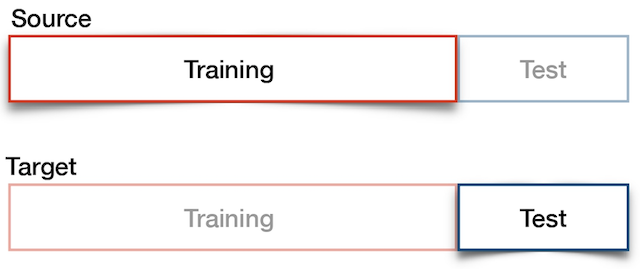

In [ ]:
# Instantiates framework
BASELINE = FrameworkType.BASELINE

#### **Network**

<p align = "justify"> After testing, analyzing and comparing the different ResNet architectures, we decided to focus on <b><a href="https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html" target="_blank">ResNet50</a></b> whose architecture was introduced in "<a href="https://arxiv.org/pdf/1512.03385.pdf" target="_blank">Deep Residual Learning for Image Recognition</a>" paper by He K., Zhang X., Ren S. & Sun J.

<p align = "justify"> One of the key innovations of the ResNet architecture is the use of <b>residual connections</b>, which allow information to bypass multiple layers in the network. This helps to alleviate the problem of vanishing gradients, which can occur when training deep neural networks. The use of residual connections enables ResNet to train much deeper networks than previous architectures, while still achieving good performance on image classification tasks. A small change with respect to the <b>ResNet18</b> and <b>ResNet34</b> that was made for the <b>50-layer ResNet</b> is that it uses a bottleneck design for the building block. A bottleneck residual block uses 1×1 convolutions, known as a “<u>bottleneck</u>”, which reduces the number of parameters and matrix multiplications. This enables much faster training of each layer. It uses a stack of three layers rather than two layers, as shown in the figure below:

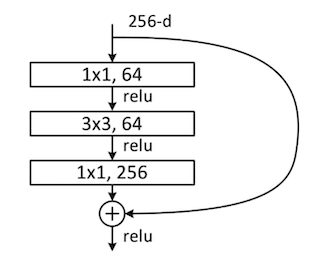

---

<p align = "justify"> ResNet50 is a 50-layer deep CNN architecture, which means it has 50 layers including convolutional, pooling, and fully connected layers. It has a total of around 25.6 million parameters, making it a very large and powerful model. The architecture of ResNet50 is composed of several building blocks called <b>residual blocks</b>. Each residual block contains several convolutional layers, batch normalization layers, and ReLU activation layers, as well as a shortcut connection. The shortcut connection allows the output of the block to be added to the input of the block, creating a residual connection. This helps to ensure that the network can learn the residual mapping between the input and output of the block, rather than the underlying mapping. ResNet50 is a very powerful model that has achieved <i>state-of-the-art</i> performance on many image classification benchmarks. It is widely used in computer vision tasks such as object detection, image segmentation, and face recognition.

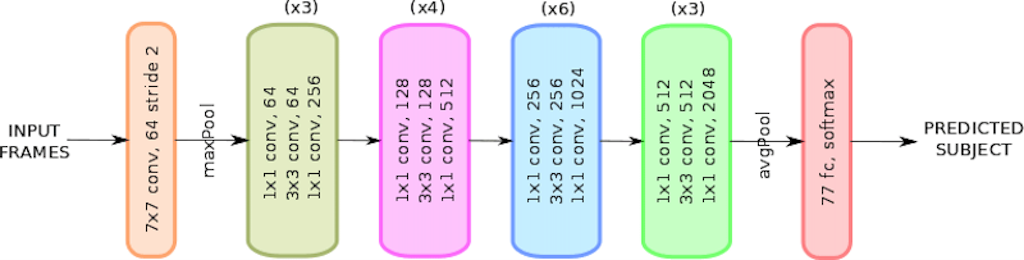

In [ ]:
def ResNet50(num_classes, forward = None):

    resnet50 = models.resnet50(pretrained = True)
    resnet50.name = 'ResNet50'
    resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes)

    if forward is not None:
        resnet50._forward_impl = types.MethodType(forward, resnet50)

    return resnet50

#### **Training step**

<p align = "justify"> ◇ <code><tt><b>training_stepRESNET50</b></tt></code>: this function defines the training step for baseline and upperbound frameworks using the ResNet50 architecture. The function first sets the model to training mode and then iterates over the training set using the data loader. For each batch of data, the function loads the data onto the device, resets the optimizer, performs a forward pass through the model to compute the outputs, computes the loss using the cross entropy loss, performs a backward pass to compute the gradients using the stochastic gradient descent, updates the model parameters using the optimizer, and computes the train loss and accuracy using the outputs and labels.

In [ ]:
def training_stepRESNET50(net, device, data_loader, optimizer, cost_function, epoch):
  
    samples = 0.
    cumulative_loss = 0.
    cumulative_accuracy = 0.

    # Set the network to training mode
    net.train()

    # Iterate over the training set
    for batch_idx, (inputs, labels) in enumerate(data_loader):

        # Load data into device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Reset the optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Loss computation
        loss = cost_function(outputs, labels)

        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Compute test loss
        samples += inputs.shape[0]
        cumulative_loss += loss.item()
        train_loss = cumulative_loss/samples

        # Compute test accuracy
        _, predicted = outputs.max(dim = 1)
        cumulative_accuracy += predicted.eq(labels).sum().item()
        train_accuracy = cumulative_accuracy/samples*100

    return train_loss, train_accuracy

#### **PRODUCT → REAL LIFE**

In [ ]:
RESNET50 = ResNet50(num_classes = NUM_CLASSES) # Instantiate the ResNet50 model
train_cost_functionRESNET50 = torch.nn.CrossEntropyLoss() # Define the cost function for training as cross entropy loss
Baseline_P_RW_test_loss = []
Baseline_P_RW_test_accuracy = []

'''
BASELINE
ResNet50
Product → Real life
Batch sizes: 128, 128
'''

main(
    net = RESNET50, device = DEVICE, framework = BASELINE,
    train_batch_size = BATCH_SIZE_128, test_batch_size = BATCH_SIZE_128,
    source_path = PRODUCT_PATH, target_path = REAL_PATH,
    training_step = training_stepRESNET50, train_cost_function = train_cost_functionRESNET50,
    test_loss_ = Baseline_P_RW_test_loss, test_acc_ = Baseline_P_RW_test_accuracy
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Before training:
	 Target loss 0.02363, Target accuracy 5.99
------------------------------------------------------------------


epochs:   7%|▋         | 1/15 [00:59<13:56, 59.75s/it]

	 Epoch: 1
	 Training loss 0.02250, Training accuracy 14.84
	 Test loss 0.02110, Test accuracy 28.12
------------------------------------------------------------------


epochs:  13%|█▎        | 2/15 [01:57<12:44, 58.83s/it]

	 Epoch: 2
	 Training loss 0.01798, Training accuracy 68.82
	 Test loss 0.01799, Test accuracy 59.64
------------------------------------------------------------------


epochs:  20%|██        | 3/15 [02:57<11:47, 58.94s/it]

	 Epoch: 3
	 Training loss 0.01241, Training accuracy 93.23
	 Test loss 0.01427, Test accuracy 74.48
------------------------------------------------------------------


epochs:  27%|██▋       | 4/15 [03:58<11:00, 60.04s/it]

	 Epoch: 4
	 Training loss 0.00781, Training accuracy 95.18
	 Test loss 0.01138, Test accuracy 78.91
------------------------------------------------------------------


epochs:  33%|███▎      | 5/15 [04:58<09:58, 59.90s/it]

	 Epoch: 5
	 Training loss 0.00485, Training accuracy 96.55
	 Test loss 0.00944, Test accuracy 80.99
------------------------------------------------------------------


epochs:  40%|████      | 6/15 [06:00<09:06, 60.76s/it]

	 Epoch: 6
	 Training loss 0.00322, Training accuracy 97.53
	 Test loss 0.00828, Test accuracy 80.73
------------------------------------------------------------------


epochs:  47%|████▋     | 7/15 [07:03<08:12, 61.53s/it]

	 Epoch: 7
	 Training loss 0.00229, Training accuracy 98.11
	 Test loss 0.00742, Test accuracy 81.51
------------------------------------------------------------------


epochs:  53%|█████▎    | 8/15 [08:08<07:17, 62.44s/it]

	 Epoch: 8
	 Training loss 0.00182, Training accuracy 98.11
	 Test loss 0.00691, Test accuracy 82.03
------------------------------------------------------------------


epochs:  60%|██████    | 9/15 [09:10<06:15, 62.51s/it]

	 Epoch: 9
	 Training loss 0.00142, Training accuracy 98.63
	 Test loss 0.00677, Test accuracy 81.77
------------------------------------------------------------------


epochs:  67%|██████▋   | 10/15 [10:10<05:07, 61.56s/it]

	 Epoch: 10
	 Training loss 0.00121, Training accuracy 98.83
	 Test loss 0.00659, Test accuracy 81.51
------------------------------------------------------------------


epochs:  73%|███████▎  | 11/15 [11:09<04:03, 60.90s/it]

	 Epoch: 11
	 Training loss 0.00099, Training accuracy 99.09
	 Test loss 0.00622, Test accuracy 82.29
------------------------------------------------------------------


epochs:  80%|████████  | 12/15 [12:15<03:07, 62.42s/it]

	 Epoch: 12
	 Training loss 0.00083, Training accuracy 99.48
	 Test loss 0.00611, Test accuracy 83.07
------------------------------------------------------------------


epochs:  87%|████████▋ | 13/15 [13:15<02:03, 61.72s/it]

	 Epoch: 13
	 Training loss 0.00071, Training accuracy 99.48
	 Test loss 0.00588, Test accuracy 83.85
------------------------------------------------------------------


epochs:  93%|█████████▎| 14/15 [14:14<01:00, 60.92s/it]

	 Epoch: 14
	 Training loss 0.00064, Training accuracy 99.61
	 Test loss 0.00581, Test accuracy 83.85
------------------------------------------------------------------


epochs: 100%|██████████| 15/15 [15:14<00:00, 60.96s/it]

	 Epoch: 15
	 Training loss 0.00057, Training accuracy 99.61
	 Test loss 0.00552, Test accuracy 85.16
------------------------------------------------------------------
After training:


	 Test loss 0.00570, Test accuracy 83.85
------------------------------------------------------------------


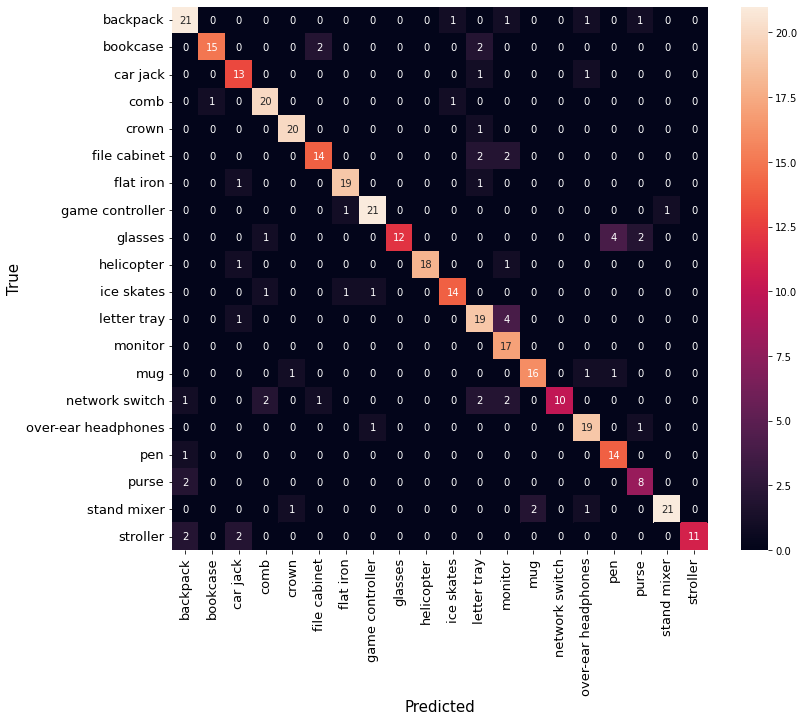

In [ ]:
get_confusion_matrix()

In [ ]:
get_classification_report()

,precision,recall,f1-score,support
backpack,0.777778,0.840000,0.807692,25.000000
bookcase,0.937500,0.789474,0.857143,19.000000
car jack,0.722222,0.866667,0.787879,15.000000
comb,0.833333,0.909091,0.869565,22.000000
crown,0.909091,0.952381,0.930233,21.000000
file cabinet,0.823529,0.777778,0.800000,18.000000
flat iron,0.904762,0.904762,0.904762,21.000000
game controller,0.913043,0.913043,0.913043,23.000000
glasses,1.000000,0.631579,0.774194,19.000000
helicopter,1.000000,0.900000,0.947368,20.000000


#### **REAL LIFE → PRODUCT**

In [ ]:
RESNET50 = ResNet50(num_classes = NUM_CLASSES) # Instantiate the ResNet50 model
train_cost_functionRESNET50 = torch.nn.CrossEntropyLoss() # Define the cost function for training as cross entropy loss
Baseline_RW_P_test_loss = []
Baseline_RW_P_test_accuracy = []

'''
BASELINE
ResNet50
Real life → Product
Batch sizes: 128, 128
'''

main(
    net = RESNET50, device = DEVICE, framework = BASELINE,
    train_batch_size = BATCH_SIZE_128, test_batch_size = BATCH_SIZE_128,
    source_path = REAL_PATH, target_path = PRODUCT_PATH,
    training_step = training_stepRESNET50, train_cost_function = train_cost_functionRESNET50,
    test_loss_ = Baseline_RW_P_test_loss, test_acc_ = Baseline_RW_P_test_accuracy
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Before training:
	 Target loss 0.02370, Target accuracy 1.04
------------------------------------------------------------------


epochs:   7%|▋         | 1/15 [01:19<18:39, 79.99s/it]

	 Epoch: 1
	 Training loss 0.02311, Training accuracy 10.94
	 Test loss 0.02129, Test accuracy 31.51
------------------------------------------------------------------


epochs:  13%|█▎        | 2/15 [02:38<17:07, 79.04s/it]

	 Epoch: 2
	 Training loss 0.01978, Training accuracy 46.88
	 Test loss 0.01770, Test accuracy 56.77
------------------------------------------------------------------


epochs:  20%|██        | 3/15 [03:58<15:54, 79.51s/it]

	 Epoch: 3
	 Training loss 0.01585, Training accuracy 80.01
	 Test loss 0.01356, Test accuracy 84.90
------------------------------------------------------------------


epochs:  27%|██▋       | 4/15 [05:17<14:32, 79.33s/it]

	 Epoch: 4
	 Training loss 0.01186, Training accuracy 89.32
	 Test loss 0.01004, Test accuracy 89.58
------------------------------------------------------------------


epochs:  33%|███▎      | 5/15 [06:37<13:15, 79.53s/it]

	 Epoch: 5
	 Training loss 0.00858, Training accuracy 93.23
	 Test loss 0.00735, Test accuracy 89.84
------------------------------------------------------------------


epochs:  40%|████      | 6/15 [07:56<11:53, 79.31s/it]

	 Epoch: 6
	 Training loss 0.00618, Training accuracy 94.86
	 Test loss 0.00568, Test accuracy 91.15
------------------------------------------------------------------


epochs:  47%|████▋     | 7/15 [09:16<10:36, 79.53s/it]

	 Epoch: 7
	 Training loss 0.00464, Training accuracy 95.57
	 Test loss 0.00470, Test accuracy 90.36
------------------------------------------------------------------


epochs:  53%|█████▎    | 8/15 [10:35<09:16, 79.50s/it]

	 Epoch: 8
	 Training loss 0.00365, Training accuracy 96.68
	 Test loss 0.00417, Test accuracy 91.93
------------------------------------------------------------------


epochs:  60%|██████    | 9/15 [11:54<07:55, 79.18s/it]

	 Epoch: 9
	 Training loss 0.00289, Training accuracy 97.20
	 Test loss 0.00372, Test accuracy 92.45
------------------------------------------------------------------


epochs:  67%|██████▋   | 10/15 [13:13<06:35, 79.16s/it]

	 Epoch: 10
	 Training loss 0.00239, Training accuracy 97.59
	 Test loss 0.00332, Test accuracy 92.45
------------------------------------------------------------------


epochs:  73%|███████▎  | 11/15 [14:31<05:15, 78.81s/it]

	 Epoch: 11
	 Training loss 0.00198, Training accuracy 97.72
	 Test loss 0.00309, Test accuracy 92.71
------------------------------------------------------------------


epochs:  80%|████████  | 12/15 [15:50<03:56, 78.92s/it]

	 Epoch: 12
	 Training loss 0.00168, Training accuracy 98.24
	 Test loss 0.00294, Test accuracy 92.71
------------------------------------------------------------------


epochs:  87%|████████▋ | 13/15 [17:12<02:39, 79.94s/it]

	 Epoch: 13
	 Training loss 0.00147, Training accuracy 98.96
	 Test loss 0.00290, Test accuracy 92.19
------------------------------------------------------------------


epochs:  93%|█████████▎| 14/15 [18:39<01:22, 82.04s/it]

	 Epoch: 14
	 Training loss 0.00124, Training accuracy 99.09
	 Test loss 0.00274, Test accuracy 92.19
------------------------------------------------------------------


epochs: 100%|██████████| 15/15 [20:12<00:00, 80.81s/it]

	 Epoch: 15
	 Training loss 0.00110, Training accuracy 99.02
	 Test loss 0.00266, Test accuracy 92.19
------------------------------------------------------------------
After training:


	 Test loss 0.00266, Test accuracy 92.19
------------------------------------------------------------------


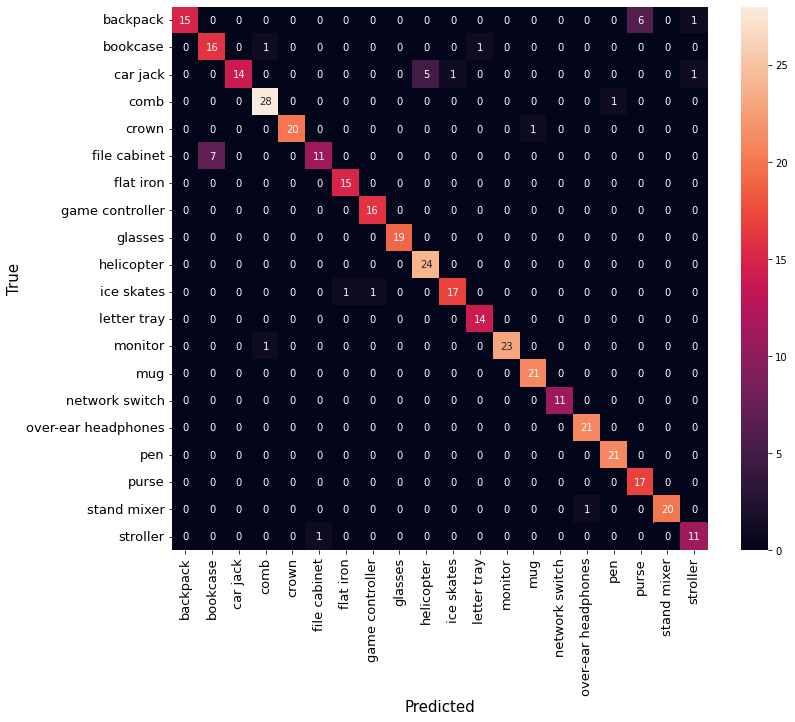

In [ ]:
get_confusion_matrix()

In [ ]:
get_classification_report()

,precision,recall,f1-score,support
backpack,1.000000,0.681818,0.810811,22.000000
bookcase,0.695652,0.888889,0.780488,18.000000
car jack,1.000000,0.666667,0.800000,21.000000
comb,0.933333,0.965517,0.949153,29.000000
crown,1.000000,0.952381,0.975610,21.000000
file cabinet,0.916667,0.611111,0.733333,18.000000
flat iron,0.937500,1.000000,0.967742,15.000000
game controller,0.941176,1.000000,0.969697,16.000000
glasses,1.000000,1.000000,1.000000,19.000000
helicopter,0.827586,1.000000,0.905660,24.000000


## **UPPER BOUND**
<p align = "justify"> A useful thing that we may want to do is computing some sort of upper bound for our task. The upper bound consists in the value of our evaluation metric that is obtained by enabling supervision on the target domain. The obtained accuracy $acc_{ub}$ can be useful for us, because we are going to assume that the performance of our UDA framework will lie somewhere in between $acc_{so}$ and $acc_{ub}$, and thus have an idea of what to reasonably expect.

---

#### **Define dataloaders**

The **UPPERBOUND** consists of the score obtained by **training** on the **target training set** and **testing** on the **target test set**.

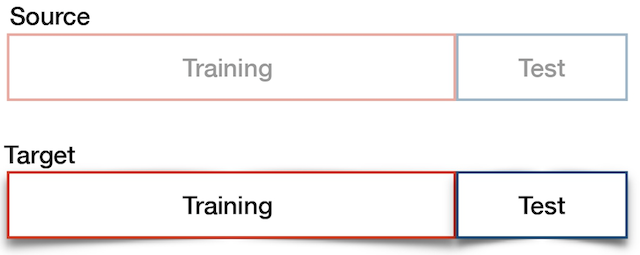

In [ ]:
# Instantiates framework
UPPERBOUND = FrameworkType.UPPERBOUND

#### **PRODUCT → REAL LIFE**

In [ ]:
RESNET50 = ResNet50(num_classes = NUM_CLASSES) # Instantiate the ResNet50 model
train_cost_functionRESNET50 = torch.nn.CrossEntropyLoss() # Define the cost function for training as cross entropy loss
Upperbound_P_RW_test_loss = []
Upperbound_P_RW_test_accuracy = []

'''
UPPERBOUND
ResNet50
Product → Real life
Batch sizes: 128, 128
'''

main( 
    net = RESNET50, device = DEVICE, framework = UPPERBOUND,
    train_batch_size = BATCH_SIZE_128, test_batch_size = BATCH_SIZE_128,
    source_path = PRODUCT_PATH, target_path = REAL_PATH,
    training_step = training_stepRESNET50, train_cost_function = train_cost_functionRESNET50,
    test_loss_ = Upperbound_P_RW_test_loss, test_acc_ = Upperbound_P_RW_test_accuracy
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Before training:
	 Target loss 0.02368, Target accuracy 5.99
------------------------------------------------------------------


epochs:   7%|▋         | 1/15 [01:21<19:01, 81.57s/it]

	 Epoch: 1
	 Training loss 0.02279, Training accuracy 14.78
	 Test loss 0.02115, Test accuracy 32.29
------------------------------------------------------------------


epochs:  13%|█▎        | 2/15 [02:44<17:47, 82.10s/it]

	 Epoch: 2
	 Training loss 0.01956, Training accuracy 52.99
	 Test loss 0.01752, Test accuracy 68.75
------------------------------------------------------------------


epochs:  20%|██        | 3/15 [04:05<16:22, 81.86s/it]

	 Epoch: 3
	 Training loss 0.01562, Training accuracy 81.32
	 Test loss 0.01376, Test accuracy 84.11
------------------------------------------------------------------


epochs:  27%|██▋       | 4/15 [05:26<14:58, 81.67s/it]

	 Epoch: 4
	 Training loss 0.01171, Training accuracy 89.06
	 Test loss 0.01022, Test accuracy 88.28
------------------------------------------------------------------


epochs:  33%|███▎      | 5/15 [06:48<13:37, 81.76s/it]

	 Epoch: 5
	 Training loss 0.00841, Training accuracy 92.19
	 Test loss 0.00767, Test accuracy 90.62
------------------------------------------------------------------


epochs:  40%|████      | 6/15 [08:09<12:12, 81.38s/it]

	 Epoch: 6
	 Training loss 0.00613, Training accuracy 94.01
	 Test loss 0.00590, Test accuracy 91.15
------------------------------------------------------------------


epochs:  47%|████▋     | 7/15 [09:31<10:51, 81.48s/it]

	 Epoch: 7
	 Training loss 0.00450, Training accuracy 95.38
	 Test loss 0.00484, Test accuracy 92.19
------------------------------------------------------------------


epochs:  53%|█████▎    | 8/15 [10:51<09:28, 81.18s/it]

	 Epoch: 8
	 Training loss 0.00351, Training accuracy 96.29
	 Test loss 0.00414, Test accuracy 91.93
------------------------------------------------------------------


epochs:  60%|██████    | 9/15 [12:13<08:07, 81.33s/it]

	 Epoch: 9
	 Training loss 0.00283, Training accuracy 97.20
	 Test loss 0.00363, Test accuracy 92.71
------------------------------------------------------------------


epochs:  67%|██████▋   | 10/15 [13:33<06:45, 81.09s/it]

	 Epoch: 10
	 Training loss 0.00235, Training accuracy 97.20
	 Test loss 0.00330, Test accuracy 92.97
------------------------------------------------------------------


epochs:  73%|███████▎  | 11/15 [14:55<05:24, 81.23s/it]

	 Epoch: 11
	 Training loss 0.00192, Training accuracy 98.18
	 Test loss 0.00295, Test accuracy 93.23
------------------------------------------------------------------


epochs:  80%|████████  | 12/15 [16:16<04:03, 81.21s/it]

	 Epoch: 12
	 Training loss 0.00160, Training accuracy 98.50
	 Test loss 0.00285, Test accuracy 92.71
------------------------------------------------------------------


epochs:  87%|████████▋ | 13/15 [17:36<02:41, 80.88s/it]

	 Epoch: 13
	 Training loss 0.00141, Training accuracy 98.57
	 Test loss 0.00265, Test accuracy 93.49
------------------------------------------------------------------


epochs:  93%|█████████▎| 14/15 [18:58<01:21, 81.04s/it]

	 Epoch: 14
	 Training loss 0.00122, Training accuracy 99.09
	 Test loss 0.00251, Test accuracy 92.71
------------------------------------------------------------------


epochs: 100%|██████████| 15/15 [20:18<00:00, 81.23s/it]

	 Epoch: 15
	 Training loss 0.00108, Training accuracy 98.83
	 Test loss 0.00234, Test accuracy 93.49
------------------------------------------------------------------
After training:


	 Test loss 0.00245, Test accuracy 92.71
------------------------------------------------------------------


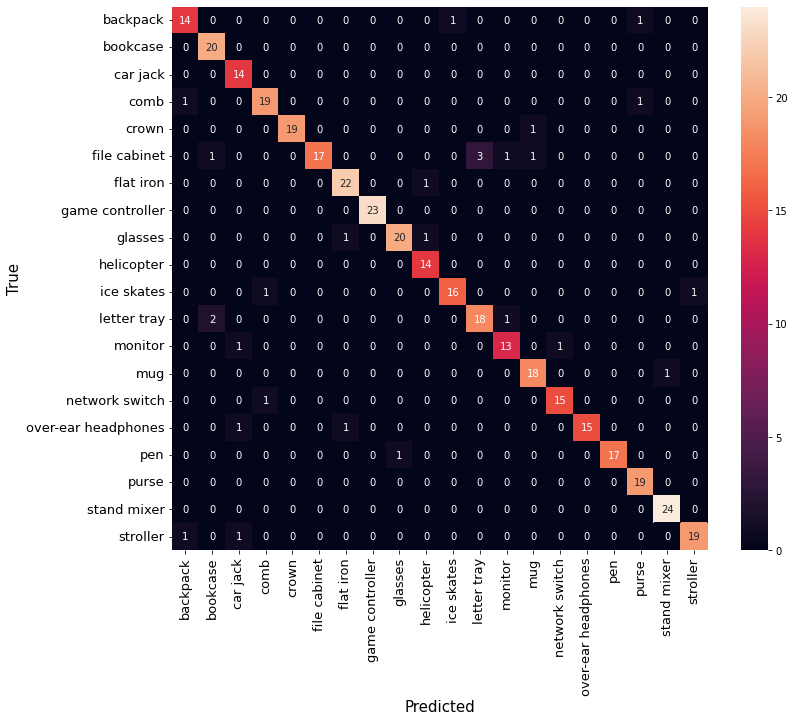

In [ ]:
get_confusion_matrix()

In [ ]:
get_classification_report()

,precision,recall,f1-score,support
backpack,0.875000,0.875000,0.875000,16.000000
bookcase,0.869565,1.000000,0.930233,20.000000
car jack,0.823529,1.000000,0.903226,14.000000
comb,0.904762,0.904762,0.904762,21.000000
crown,1.000000,0.950000,0.974359,20.000000
file cabinet,1.000000,0.739130,0.850000,23.000000
flat iron,0.916667,0.956522,0.936170,23.000000
game controller,1.000000,1.000000,1.000000,23.000000
glasses,0.952381,0.909091,0.930233,22.000000
helicopter,0.875000,1.000000,0.933333,14.000000


#### **REAL LIFE → PRODUCT**

In [ ]:
RESNET50 = ResNet50(num_classes = NUM_CLASSES) # Instantiate the ResNet50 model
train_cost_functionRESNET50 = torch.nn.CrossEntropyLoss() # Define the cost function for training as cross entropy loss
Upperbound_RW_P_test_loss = []
Upperbound_RW_P_test_accuracy = []

'''
UPPERBOUND
ResNet50
Real life → Product
Batch sizes: 128, 128
'''

main(
    net = RESNET50, device = DEVICE, framework = UPPERBOUND,
    train_batch_size = BATCH_SIZE_128, test_batch_size = BATCH_SIZE_128,
    source_path = REAL_PATH, target_path = PRODUCT_PATH,
    training_step = training_stepRESNET50, train_cost_function = train_cost_functionRESNET50,
    test_loss_ = Upperbound_RW_P_test_loss, test_acc_ = Upperbound_RW_P_test_accuracy
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Before training:
	 Target loss 0.02350, Target accuracy 6.77
------------------------------------------------------------------


epochs:   7%|▋         | 1/15 [00:54<12:43, 54.52s/it]

	 Epoch: 1
	 Training loss 0.02259, Training accuracy 15.89
	 Test loss 0.02036, Test accuracy 47.40
------------------------------------------------------------------


epochs:  13%|█▎        | 2/15 [01:49<11:52, 54.80s/it]

	 Epoch: 2
	 Training loss 0.01819, Training accuracy 67.45
	 Test loss 0.01555, Test accuracy 78.65
------------------------------------------------------------------


epochs:  20%|██        | 3/15 [02:43<10:55, 54.60s/it]

	 Epoch: 3
	 Training loss 0.01287, Training accuracy 88.74
	 Test loss 0.01042, Test accuracy 90.89
------------------------------------------------------------------


epochs:  27%|██▋       | 4/15 [03:39<10:06, 55.18s/it]

	 Epoch: 4
	 Training loss 0.00831, Training accuracy 94.73
	 Test loss 0.00660, Test accuracy 95.57
------------------------------------------------------------------


epochs:  33%|███▎      | 5/15 [04:35<09:12, 55.29s/it]

	 Epoch: 5
	 Training loss 0.00526, Training accuracy 96.09
	 Test loss 0.00436, Test accuracy 95.83
------------------------------------------------------------------


epochs:  40%|████      | 6/15 [05:30<08:17, 55.25s/it]

	 Epoch: 6
	 Training loss 0.00347, Training accuracy 97.33
	 Test loss 0.00317, Test accuracy 95.57
------------------------------------------------------------------


epochs:  47%|████▋     | 7/15 [06:26<07:24, 55.51s/it]

	 Epoch: 7
	 Training loss 0.00251, Training accuracy 97.66
	 Test loss 0.00254, Test accuracy 96.09
------------------------------------------------------------------


epochs:  53%|█████▎    | 8/15 [07:21<06:27, 55.42s/it]

	 Epoch: 8
	 Training loss 0.00189, Training accuracy 98.50
	 Test loss 0.00206, Test accuracy 96.35
------------------------------------------------------------------


epochs:  60%|██████    | 9/15 [08:17<05:32, 55.40s/it]

	 Epoch: 9
	 Training loss 0.00149, Training accuracy 98.76
	 Test loss 0.00183, Test accuracy 96.09
------------------------------------------------------------------


epochs:  67%|██████▋   | 10/15 [09:13<04:38, 55.70s/it]

	 Epoch: 10
	 Training loss 0.00122, Training accuracy 98.96
	 Test loss 0.00164, Test accuracy 97.40
------------------------------------------------------------------


epochs:  73%|███████▎  | 11/15 [10:08<03:42, 55.60s/it]

	 Epoch: 11
	 Training loss 0.00104, Training accuracy 99.02
	 Test loss 0.00150, Test accuracy 97.14
------------------------------------------------------------------


epochs:  80%|████████  | 12/15 [11:05<02:47, 55.82s/it]

	 Epoch: 12
	 Training loss 0.00089, Training accuracy 99.41
	 Test loss 0.00141, Test accuracy 97.14
------------------------------------------------------------------


epochs:  87%|████████▋ | 13/15 [12:00<01:51, 55.59s/it]

	 Epoch: 13
	 Training loss 0.00075, Training accuracy 99.74
	 Test loss 0.00135, Test accuracy 96.88
------------------------------------------------------------------


epochs:  93%|█████████▎| 14/15 [12:55<00:55, 55.45s/it]

	 Epoch: 14
	 Training loss 0.00064, Training accuracy 99.67
	 Test loss 0.00122, Test accuracy 97.14
------------------------------------------------------------------


epochs: 100%|██████████| 15/15 [13:51<00:00, 55.45s/it]

	 Epoch: 15
	 Training loss 0.00058, Training accuracy 99.80
	 Test loss 0.00120, Test accuracy 97.14
------------------------------------------------------------------
After training:


	 Test loss 0.00117, Test accuracy 97.14
------------------------------------------------------------------


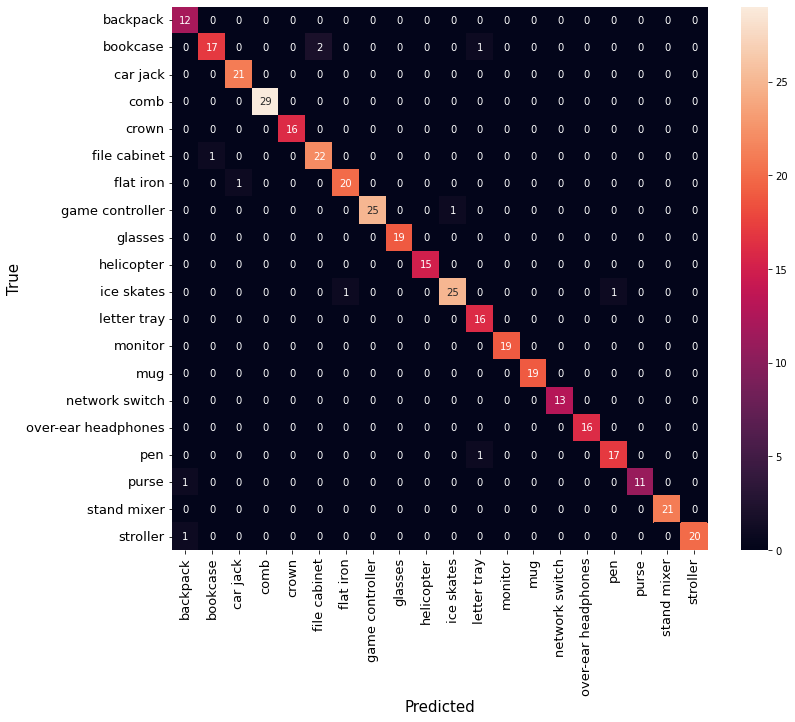

In [ ]:
get_confusion_matrix()

In [ ]:
get_classification_report()

,precision,recall,f1-score,support
backpack,0.857143,1.000000,0.923077,12.000000
bookcase,0.944444,0.850000,0.894737,20.000000
car jack,0.954545,1.000000,0.976744,21.000000
comb,1.000000,1.000000,1.000000,29.000000
crown,1.000000,1.000000,1.000000,16.000000
file cabinet,0.916667,0.956522,0.936170,23.000000
flat iron,0.952381,0.952381,0.952381,21.000000
game controller,1.000000,0.961538,0.980392,26.000000
glasses,1.000000,1.000000,1.000000,19.000000
helicopter,1.000000,1.000000,1.000000,15.000000


## **UDA**

<p align = "justify"> Now we want to evaluate our UDA component which implies training on the target domain. Since we are not allowed to use labels there, here we will use any UDA device of our choice. We will achieve a new accuracy $acc_{uda}$, which hopefully will be higher than $acc_{so}$ since this time we also trained on the target domain, even if without label information.

---

#### **Define dataloaders**

The **UDA** consists of the score obtained by **training** *supervisedly* on the **source training set** and *unsupervisedly* on the **target training set** and **testing** on the **target test set**.

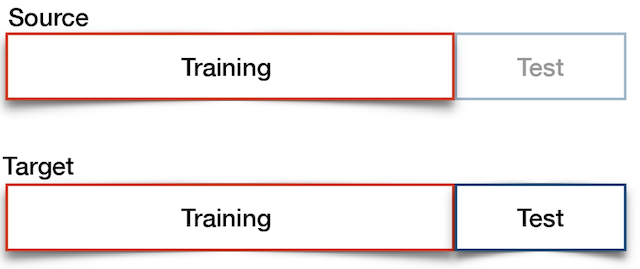

In [ ]:
# Instantiates framework
UDA = FrameworkType.UDA

<p align = "justify"> Before going to see our implemented models one by one, let's take a general overview of what we have studied about Unsupervised Domain Adaptation to understand the reasons for our implementation choices. 

<p align = "justify"> We have seen there are 3 main categories of Deep Domain Adaptation:
<ol> 
<li> <b>Discrepancy-based methods</b>: align domain data representations with statistical measures.</li>
<li> <b>Adversarial-based methods</b>: generally involve a domain discriminator to enforce domain confusion.</li>
<li> <b>Reconstruction-based methods</b>: uses an auxiliary reconstruction task to ensure a “good” domain-invariant feature representation.</li>
</ol>

<p align = "justify"> For this reason we decided to train and test different models for each of the three categories, in order to compare them and see which performs better. Two features common to all models are:
<ul>
<li> <p align = "justify">use of ResNet50 as backbone or feature extractor, because our intention was to start from the model used for the baseline and upperbound by inserting it into a more structured UDA model that would provide better performance;</li>
<li> <p align = "justify">use of the stochastic gradient descent (SGD) optimizer, because anyway it has always provided better performance than optimization algorithms like Adam, Adagrad, RMSprop and L-BFGS, etc.</li>
</ul>

<p align = "justify"> After analyzing the performance of the various models, the ones implemented below represent the UDA models that provided us the best performance in terms of accuracy:
<ol> 
<li> <u>Discrepancy-based methods</u>: <b>Deep CORAL</b> (<b>CORrelation ALignment</b>)</li>
<li> <u>Adversarial-based methods</u>: <b>DANN</b> (<b>Domain-Adversarial Neural Network</b>)</li>
<li> <u>Reconstruction-based methods</u>: <b>DSN</b> (<b>Domain Separation Networks</b>)</li>
</ol>

---

Before looking at our models, let's describe a function below that will be used by both DANN and DSN models.

<p align = "justify"> ◇ <code><tt><b>GradientReversal</b></tt></code>: is a technique commonly used in domain adaptation, which is the process of training machine learning models on one domain (e.g. source domain) and then adapting them to work well on a different domain (e.g. target domain) with limited labeled data. Its purpose is to <u>reverse the sign of the gradients flowing through it during backpropagation, allowing the model to learn features that are specific to the source domain while ignoring those specific to the target domain</u>. This class implements the forward and backward passes of the GRL. By using this class, we can apply the GRL technique in our models and try to achieve better generalization performance when using the model on the target domain. Mathematically, we can formally treat the gradient reversal layer as a “pseudo-function” $R(x)$ defined by two (incompatible) equations describing its forward and backpropagation behaviour ($I$ is an identity matrix):

\begin{gather}R(x) = x \quad \quad \quad \frac{dR}{dx} = -I\end{gather}

In [ ]:
class GradientReversal(Function):
    def forward(ctx, x, grl_lambda):
        ctx.grl_lambda = grl_lambda   
        return x.view_as(x)           

    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.grl_lambda  
        return output, None                         

### **Deep CORAL**

<p align = "justify"> The idea of <b><u>Deep CORrelation ALignment</b></u> (<b><u>Deep CORAL</u></b>) is proposed in "<a href="https://arxiv.org/pdf/1607.01719.pdf" target="_blank">Deep CORAL: Correlation Alignment for Deep Domain Adaptation</a>" by S. Baochen & K. Saenko, <i>European conference on computer vision</i>. Springer, Cham (2016).

<p align = "justify"> In this paper, the authors propose an extension to a previously proposed method called CORAL, which is a “frustratingly easy” method for unsupervised domain adaptation where the target domain is unlabeled. The original <a href="https://arxiv.org/pdf/1511.05547.pdf" target="_blank">CORAL</a> method aligns the <u>second-order statistics of the source and target distributions</u>, but it relies on a linear transformation and is not end-to-end.

<p align = "justify"> In this work, the authors propose a new method called Deep CORAL that incorporates CORAL directly into deep neural networks. This is done by constructing a <u>differentiable loss function that minimizes the difference between source and target correlations</u>. This approach is more powerful than the original CORAL method, as it learns a <u>non-linear transformation</u> that is better suited for deep CNNs. The proposed Deep CORAL approach is similar to other methods, such as DDC, DAN, and ReverseGrad, in that it adds a new loss (<b>CORAL loss</b>) to minimize the difference in learned feature covariances across domains. However, it is more powerful than DDC, simpler to optimize than DAN and ReverseGrad, and can be integrated into different layers or architectures seamlessly.

#### **Network**

<p align = "justify"> The first goal can be achieved by initializing the network parameters from the generic pre-trained network and fine-tuning it on the labelled source data, and we also want the final learned features to work well on the target domain. 
<b>The authors of the paper refer to Deep CORAL as any deep network incorporating the CORAL loss for domain adaptation.</b> In one of the official Deep CORAL codes on <a href="https://github.com/SSARCandy/DeepCORAL" target="_blank">Github</a> the network is implemented with two main components: a shared neural network AlexNet that represents the main feature extractor and it is used to extract features from both the source and target data, and a fully connected layer that is used to classify the extracted features into different classes.

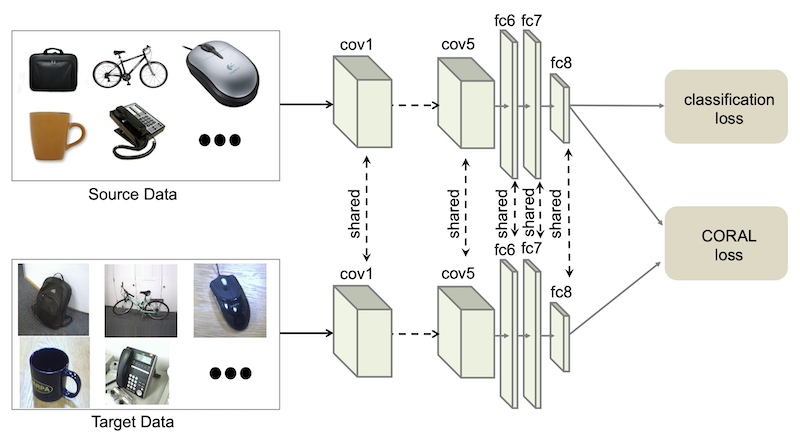


---

<p align = "justify"> ◇ <code><tt><b>DeepCORALforward</b></tt></code>: in our case, we have decided to initialize the network parameters from the pre-trained ResNet50, but we have modified its forward method by passing this function as the <code><tt>forward</tt></code> argument. It starts with the standard ResNet50 forward method by running the input through the convolutional and max-pooling layers, and the residual blocks, then applies average pooling and reshape the output before returning it.

<p align = "justify"> ◇ <code><tt><b>DeepCORAL</b></tt></code>: this model has been modified with respect to the original one for improving the transfer representation learning: we have detached the classification layer <code><tt>fc</code></tt> that was after the <code><tt>avgpool layer</code></tt> and then appended a <code><tt>bottleneck</code></tt>, which is a linear layer with 512 input units and 256 output units, to further reduce the dimension of the information before classification.

In [ ]:
def DeepCORALforward(self, x):

    # Pass the input through the convolutional layers
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    # Pass the input through the residual blocks
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    # Apply average pooling and reshape the output
    x = self.avgpool(x)
    output = x.view(x.size(0), -1)

    return output

class DeepCORAL(nn.Module):
    def __init__(self, num_classes):
        super(DeepCORAL, self).__init__()
        self.name = 'DeepCORAL'
        self.sharedNet = ResNet50(num_classes, DeepCORALforward) # Create an instance of the ResNet50 model with custom forward method
        self.avgpool = self.sharedNet.avgpool
        self.bottleneck = nn.Linear(self.sharedNet.fc.in_features, 256) # Append a bottleneck to reduce the dimension of the information
        self.fc = nn.Linear(256, num_classes)

    def forward(self, source, target):
        source = self.sharedNet(source)
        source = self.bottleneck(source)
        source = self.fc(source)

        target = self.sharedNet(target)
        target = self.bottleneck(target)
        target = self.fc(target)

        return source, target

#### **Cost function**

<p align = "justify"> For the second goal, the authors propose to minimize the difference in second-order statistics (covariances) between the source and target feature activations, i.e. the <b>CORAL loss</b>. It is defined as follows:

$$\ell_{CORAL} = \frac{1}{4d^2} ||C_S - C_T||_F^2$$

where:
- $d$ represents the size of deep layer activations,
- $||\cdot||_F^2$ denotes the squared matrix [Frobenius norm](https://mathworld.wolfram.com/FrobeniusNorm.html),
- $C_S$ and $C_T$ denote the feature covariance matrices of the source and target data defined as follows:

\begin{gather} C_S = \frac{1}{n_S - 1}\left(D_S^\top D_S - \frac{1}{n_S}(1^\top D_S)^\top(1^\top D_S)\right) \quad \quad \quad C_T = \frac{1}{n_T - 1}\left(D_T^\top D_T - \frac{1}{n_T}(1^\top D_T)^\top(1^\top D_T)\right)\end{gather}
where:
  - $n_S$ and $n_T$ are the number of source and target data respectively,
  - $D_S^{ij}$ and $D_T^{ij}$ indicate the $j$-th dimension of the $i$-th source and target data examples. 


<p align = "justify"> The goal of the final deep features is to be both discriminative and domain invariant. Training the model only with the classification loss (in our case, Cross Entropy loss) can cause overfitting to the source domain and poor performance on the target domain. On the other hand, training with the CORAL loss alone may result in degenerated features. Therefore, we have trained the model with both the classification loss and the CORAL loss that is likely to learn features that work well on the target domain:

$$ \ell_{TOTAL} = \ell_{CLASSIFICATION} + λ\ell_{CORAL}$$

where $\lambda$ denotes a weight that trades off the adaptation with classification accuracy on the source domain. These two losses play counterparts and reach an equilibrium at the end of training, where the final features are expected to work well on the target domain.


In [ ]:
class CORAL_Loss(nn.Module):
    def __init__(self):
        super(CORAL_Loss, self).__init__()

    def forward(self, outputs_source, labels_source, outputs_target, lambda_weight):
        
        ### CLASSIFICATION LOSS ###
        classification_loss = torch.nn.functional.cross_entropy(outputs_source, labels_source)

        ### CORAL LOSS ###
        d = outputs_source.data.shape[1]

        # Compute the mean of source and target outputs and subtract them from their respective outputs
        xm = torch.mean(outputs_source, 0, keepdim=True) - outputs_source
        xmt = torch.mean(outputs_target, 0, keepdim=True) - outputs_target

        # Compute the covariance matrix of the source outputs and the target outputs
        xc = xm.t() @ xm
        xct = xmt.t() @ xmt

        # Compute the CORAL loss as the Frobenius norm between outputs_source and outputs_target
        coral_loss = torch.mean(torch.mul((xc - xct), (xc - xct))) / (4 * d * d)

        ### TOTAL LOSS ###
        loss = classification_loss + lambda_weight * coral_loss

        return loss

#### **Training step**

<p align = "justify"> ◇ <code><tt><b>training_stepCORAL</b></tt></code>: this function includes all the necessary steps to train the DeepCORAL network on the provided training data such as loading the data, forwarding the data through the network, computing the CORAL loss, backpropagating the gradients and updating the network parameters. We can notice that the λ parameter is calculated as the ratio of the current epoch number to the total number of training epochs, allowing the weight of the CORAL loss term to increase over the course of training.

 

In [ ]:
def training_stepCORAL(net, device, data_loader, optimizer, cost_function, epoch):
  
    samples = 0.
    cumulative_loss = 0.
    cumulative_accuracy = 0.

    # Set the network to training mode
    net.train()

    # Iterate over the training set
    for batch in enumerate(data_loader):
        batch_idx, (inputs_source, labels_source, inputs_target) = batch

        # Load data into device
        inputs_source = inputs_source.to(device)
        inputs_target = inputs_target.to(device)
        labels_source = labels_source.to(device)

        # Reset the optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs_source, outputs_target = net(inputs_source, inputs_target)

        # Loss computation
        lambda_weight = (epoch + 1) / NUM_EPOCHS
        loss = cost_function(outputs_source, labels_source, outputs_target, lambda_weight)

        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Compute training loss
        samples += inputs_source.shape[0]
        cumulative_loss += loss.item()
        train_loss = cumulative_loss/samples

        # Compute training accuracy
        _, predicted = outputs_source.max(dim = 1)
        cumulative_accuracy += predicted.eq(labels_source).sum().item()
        train_accuracy = cumulative_accuracy / samples * 100

    return train_loss, train_accuracy

#### **PRODUCT → REAL LIFE**

In [ ]:
CORAL = DeepCORAL(num_classes = NUM_CLASSES) # Instantiate the DeepCORAL model
train_cost_functionCORAL = CORAL_Loss() # Define the cost function for training as CORAL loss
CORAL_P_RW_test_loss = []
CORAL_P_RW_test_accuracy = []

'''
UDA
DeepCORAL
Product → Real life
Batch sizes: 64(x2), 128
'''

main(
    net = CORAL, device = DEVICE, framework = UDA,
    train_batch_size = BATCH_SIZE_64, test_batch_size = BATCH_SIZE_128,
    source_path = PRODUCT_PATH, target_path = REAL_PATH,
    training_step = training_stepCORAL, train_cost_function = train_cost_functionCORAL,
    test_loss_ = CORAL_P_RW_test_loss, test_acc_ = CORAL_P_RW_test_accuracy
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Before training:
	 Target loss 0.02353, Target accuracy 6.77
------------------------------------------------------------------


epochs:   7%|▋         | 1/15 [02:13<31:11, 133.70s/it]

	 Epoch: 1
	 Training loss 0.04489, Training accuracy 19.38
	 Test loss 0.02142, Test accuracy 41.67
------------------------------------------------------------------


epochs:  13%|█▎        | 2/15 [04:29<29:13, 134.92s/it]

	 Epoch: 2
	 Training loss 0.03640, Training accuracy 77.75
	 Test loss 0.01800, Test accuracy 73.44
------------------------------------------------------------------


epochs:  20%|██        | 3/15 [06:45<27:02, 135.21s/it]

	 Epoch: 3
	 Training loss 0.02557, Training accuracy 92.12
	 Test loss 0.01389, Test accuracy 83.07
------------------------------------------------------------------


epochs:  27%|██▋       | 4/15 [09:01<24:53, 135.76s/it]

	 Epoch: 4
	 Training loss 0.01579, Training accuracy 95.00
	 Test loss 0.01015, Test accuracy 85.68
------------------------------------------------------------------


epochs:  33%|███▎      | 5/15 [11:18<22:40, 136.02s/it]

	 Epoch: 5
	 Training loss 0.00962, Training accuracy 97.25
	 Test loss 0.00810, Test accuracy 85.68
------------------------------------------------------------------


epochs:  40%|████      | 6/15 [13:33<20:21, 135.73s/it]

	 Epoch: 6
	 Training loss 0.00711, Training accuracy 97.44
	 Test loss 0.00678, Test accuracy 85.68
------------------------------------------------------------------


epochs:  47%|████▋     | 7/15 [15:48<18:05, 135.72s/it]

	 Epoch: 7
	 Training loss 0.00581, Training accuracy 98.44
	 Test loss 0.00608, Test accuracy 86.98
------------------------------------------------------------------


epochs:  53%|█████▎    | 8/15 [18:05<15:51, 135.87s/it]

	 Epoch: 8
	 Training loss 0.00521, Training accuracy 98.88
	 Test loss 0.00567, Test accuracy 86.98
------------------------------------------------------------------


epochs:  60%|██████    | 9/15 [20:27<13:46, 137.82s/it]

	 Epoch: 9
	 Training loss 0.00471, Training accuracy 99.00
	 Test loss 0.00547, Test accuracy 87.50
------------------------------------------------------------------


epochs:  67%|██████▋   | 10/15 [22:50<11:36, 139.38s/it]

	 Epoch: 10
	 Training loss 0.00426, Training accuracy 99.38
	 Test loss 0.00524, Test accuracy 88.54
------------------------------------------------------------------


epochs:  73%|███████▎  | 11/15 [25:16<09:25, 141.42s/it]

	 Epoch: 11
	 Training loss 0.00430, Training accuracy 99.31
	 Test loss 0.00511, Test accuracy 87.50
------------------------------------------------------------------


epochs:  80%|████████  | 12/15 [27:39<07:05, 141.88s/it]

	 Epoch: 12
	 Training loss 0.00424, Training accuracy 99.69
	 Test loss 0.00513, Test accuracy 88.02
------------------------------------------------------------------


epochs:  87%|████████▋ | 13/15 [30:05<04:46, 143.12s/it]

	 Epoch: 13
	 Training loss 0.00405, Training accuracy 99.62
	 Test loss 0.00503, Test accuracy 88.02
------------------------------------------------------------------


epochs:  93%|█████████▎| 14/15 [32:35<02:25, 145.35s/it]

	 Epoch: 14
	 Training loss 0.00396, Training accuracy 99.94
	 Test loss 0.00495, Test accuracy 88.80
------------------------------------------------------------------


epochs: 100%|██████████| 15/15 [35:02<00:00, 140.13s/it]

	 Epoch: 15
	 Training loss 0.00399, Training accuracy 99.75
	 Test loss 0.00490, Test accuracy 89.06
------------------------------------------------------------------
After training:


	 Test loss 0.00492, Test accuracy 89.06
------------------------------------------------------------------


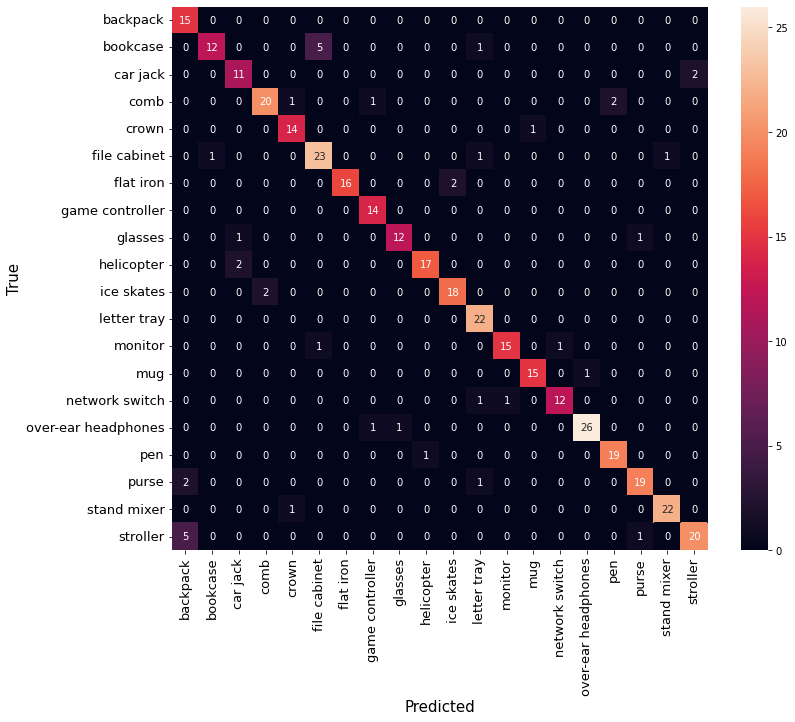

In [ ]:
get_confusion_matrix()

In [ ]:
get_classification_report()

,precision,recall,f1-score,support
backpack,0.681818,1.000000,0.810811,15.000000
bookcase,0.923077,0.666667,0.774194,18.000000
car jack,0.785714,0.846154,0.814815,13.000000
comb,0.909091,0.833333,0.869565,24.000000
crown,0.875000,0.933333,0.903226,15.000000
file cabinet,0.793103,0.884615,0.836364,26.000000
flat iron,1.000000,0.888889,0.941176,18.000000
game controller,0.875000,1.000000,0.933333,14.000000
glasses,0.923077,0.857143,0.888889,14.000000
helicopter,0.944444,0.894737,0.918919,19.000000


#### **REAL LIFE → PRODUCT**

In [ ]:
CORAL = DeepCORAL(num_classes = NUM_CLASSES) # Instantiate the DeepCORAL model
train_cost_functionCORAL = CORAL_Loss() # Define the cost function for training as CORAL loss
CORAL_RW_P_test_loss = []
CORAL_RW_P_test_accuracy = []

'''
UDA
DeepCORAL
Real life → Product
Batch sizes: 64(x2), 128
'''

main(
    net = CORAL, device = DEVICE, framework = UDA,
    train_batch_size = BATCH_SIZE_64, test_batch_size = BATCH_SIZE_128,
    source_path = REAL_PATH, target_path = PRODUCT_PATH,
    training_step = training_stepCORAL, train_cost_function = train_cost_functionCORAL,
    test_loss_ = CORAL_RW_P_test_loss, test_acc_ = CORAL_RW_P_test_accuracy
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Before training:
	 Target loss 0.02349, Target accuracy 10.68
------------------------------------------------------------------


epochs:   7%|▋         | 1/15 [02:05<29:22, 125.88s/it]

	 Epoch: 1
	 Training loss 0.04534, Training accuracy 21.19
	 Test loss 0.02105, Test accuracy 54.69
------------------------------------------------------------------


epochs:  13%|█▎        | 2/15 [04:15<27:42, 127.86s/it]

	 Epoch: 2
	 Training loss 0.03913, Training accuracy 65.38
	 Test loss 0.01734, Test accuracy 85.68
------------------------------------------------------------------


epochs:  20%|██        | 3/15 [06:23<25:35, 127.95s/it]

	 Epoch: 3
	 Training loss 0.03101, Training accuracy 88.19
	 Test loss 0.01276, Test accuracy 88.80
------------------------------------------------------------------


epochs:  27%|██▋       | 4/15 [08:31<23:30, 128.24s/it]

	 Epoch: 4
	 Training loss 0.02204, Training accuracy 90.69
	 Test loss 0.00855, Test accuracy 89.32
------------------------------------------------------------------


epochs:  33%|███▎      | 5/15 [10:39<21:21, 128.13s/it]

	 Epoch: 5
	 Training loss 0.01481, Training accuracy 92.62
	 Test loss 0.00565, Test accuracy 91.93
------------------------------------------------------------------


epochs:  40%|████      | 6/15 [12:47<19:12, 128.04s/it]

	 Epoch: 6
	 Training loss 0.01041, Training accuracy 94.88
	 Test loss 0.00417, Test accuracy 94.53
------------------------------------------------------------------


epochs:  47%|████▋     | 7/15 [14:56<17:05, 128.15s/it]

	 Epoch: 7
	 Training loss 0.00832, Training accuracy 96.38
	 Test loss 0.00349, Test accuracy 93.75
------------------------------------------------------------------


epochs:  53%|█████▎    | 8/15 [17:07<15:04, 129.16s/it]

	 Epoch: 8
	 Training loss 0.00713, Training accuracy 97.19
	 Test loss 0.00301, Test accuracy 94.79
------------------------------------------------------------------


epochs:  60%|██████    | 9/15 [19:19<13:01, 130.24s/it]

	 Epoch: 9
	 Training loss 0.00654, Training accuracy 98.12
	 Test loss 0.00276, Test accuracy 93.75
------------------------------------------------------------------


epochs:  67%|██████▋   | 10/15 [21:30<10:51, 130.37s/it]

	 Epoch: 10
	 Training loss 0.00586, Training accuracy 98.56
	 Test loss 0.00277, Test accuracy 94.79
------------------------------------------------------------------


epochs:  73%|███████▎  | 11/15 [23:40<08:41, 130.33s/it]

	 Epoch: 11
	 Training loss 0.00533, Training accuracy 98.94
	 Test loss 0.00275, Test accuracy 94.53
------------------------------------------------------------------


epochs:  80%|████████  | 12/15 [25:51<06:31, 130.45s/it]

	 Epoch: 12
	 Training loss 0.00530, Training accuracy 99.38
	 Test loss 0.00271, Test accuracy 94.53
------------------------------------------------------------------


epochs:  87%|████████▋ | 13/15 [28:02<04:20, 130.46s/it]

	 Epoch: 13
	 Training loss 0.00498, Training accuracy 99.38
	 Test loss 0.00267, Test accuracy 93.75
------------------------------------------------------------------


epochs:  93%|█████████▎| 14/15 [30:20<02:12, 132.75s/it]

	 Epoch: 14
	 Training loss 0.00490, Training accuracy 99.69
	 Test loss 0.00267, Test accuracy 94.53
------------------------------------------------------------------


epochs: 100%|██████████| 15/15 [32:33<00:00, 130.25s/it]

	 Epoch: 15
	 Training loss 0.00470, Training accuracy 99.81
	 Test loss 0.00266, Test accuracy 94.79
------------------------------------------------------------------
After training:


	 Test loss 0.00270, Test accuracy 94.53
------------------------------------------------------------------


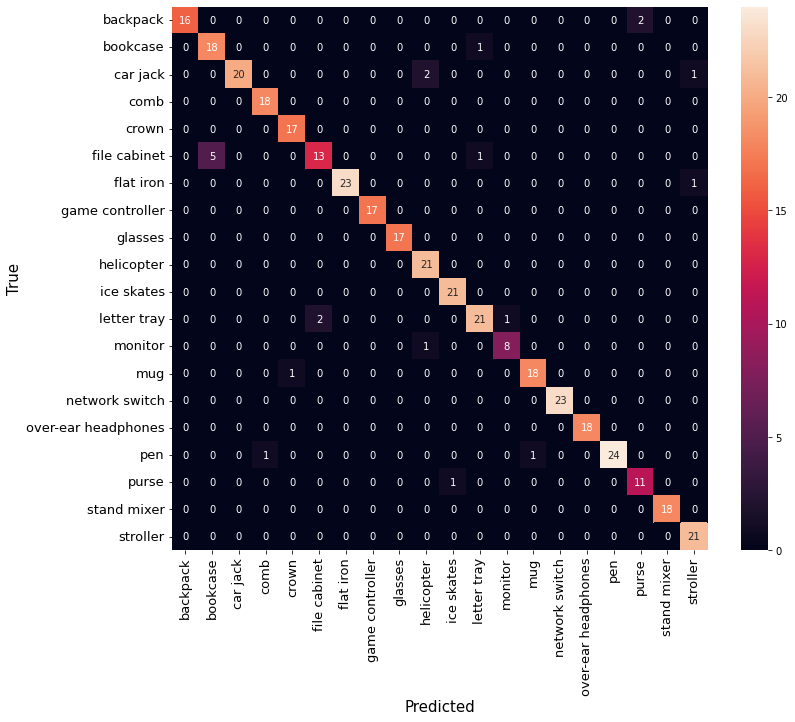

In [ ]:
get_confusion_matrix()

In [ ]:
get_classification_report()

,precision,recall,f1-score,support
backpack,1.000000,0.888889,0.941176,18.000000
bookcase,0.782609,0.947368,0.857143,19.000000
car jack,1.000000,0.869565,0.930233,23.000000
comb,0.947368,1.000000,0.972973,18.000000
crown,0.944444,1.000000,0.971429,17.000000
file cabinet,0.866667,0.684211,0.764706,19.000000
flat iron,1.000000,0.958333,0.978723,24.000000
game controller,1.000000,1.000000,1.000000,17.000000
glasses,1.000000,1.000000,1.000000,17.000000
helicopter,0.875000,1.000000,0.933333,21.000000


### **DANN**

<p align = "justify"> Adversarial-based methods are a popular class of machine learning algorithms that have been proposed for unsupervised domain adaptation (UDA). These methods use an adversarial training process to learn a desired function or representation, with the goal of training a model on one domain and adapting it to perform well on another domain without additional labeled data from the target domain. They are widely used in tasks such as image generation, image-to-image translation, and domain adaptation. Among the various adversarial-based methods for UDA, we have seen the <i>ADDA</i> (Adversarial Discriminative Domain Adaptation), <i>JAN</i> (Joint Adaptation Networks), <i>CDAN</i> (Conditional Adversarial Domain Adaptation), and <i>MCD</i> (Maximum Classifier Discrepancy) models. These models all have different approaches to aligning the feature distributions of the source and target domains and achieving domain-invariant features.

<p align = "justify"> At the end of the day, we focused our attention on the <b>DANN</b> (<b>Domain Adversarial Neural Network</b>) model, whose idea is proposed in "<a href="https://arxiv.org/pdf/1505.07818.pdf" target="_blank">Domain-Adversarial Training of Neural Networks</a>" by Y. Ganin, et al., <i>The journal of machine learning research</i> (2016).

<p align = "justify"> The authors' approach promotes the emergence of features that are <u>discriminative for the main learning task on the source domain</u> and <u>indiscriminate with respect to the shift between the domains</u>. So, the authors focus on learning features that combine <b>discriminativeness</b> and <b>domain-invariance</b>, achieving it by jointly optimizing the underlying features as well as two discriminative classifiers operating on these features: the <u>label predictor that predicts class labels and is used both during training and test steps</u> and the <u>domain classifier that discriminates between the source and the target domains during training</u>. While the parameters of the classifiers are optimized in order to minimize their error on the training set, the parameters of the underlying deep feature mapping are optimized in order to minimize the loss of the label classifier and to maximize the loss of the domain classifier. The latter update thus works <i>adversarially</i> to the domain classifier, and it encourages domain-invariant features to emerge in the course of the optimization. We show that all three training processes can be embedded into our deep feed-forward network DANN that uses standard layers and loss functions, can be trained using standard backpropagation algorithms based on stochastic gradient descent, and can thus be implemented with little effort using any of the deep learning packages.


#### **Network**

<p align = "justify"> The proposed architecture includes a deep <b><font color='green'>feature extractor</font></b> (<code><tt>features</tt></code> and <code><tt>bottleneck</tt></code>) and a <b><font color='blue'>deep label predictor</font></b> (<code><tt>classifier</tt></code>), which together form a standard feed-forward architecture. Unsupervised domain adaptation is achieved by adding a <b><font color='red'>domain classifier</font></b> (<code><tt>discriminator</tt></code>) connected to the feature extractor via a gradient reversal layer that multiplies the gradient by a certain negative constant during the backpropagation-based training. Otherwise, the training proceeds standardly and minimizes the label prediction loss (for source data) and the domain classification loss (for all samples). Gradient reversal ensures that the feature distributions over the two domains are made similar (as indistinguishable as possible for the domain classifier), thus resulting in the domain-invariant features.

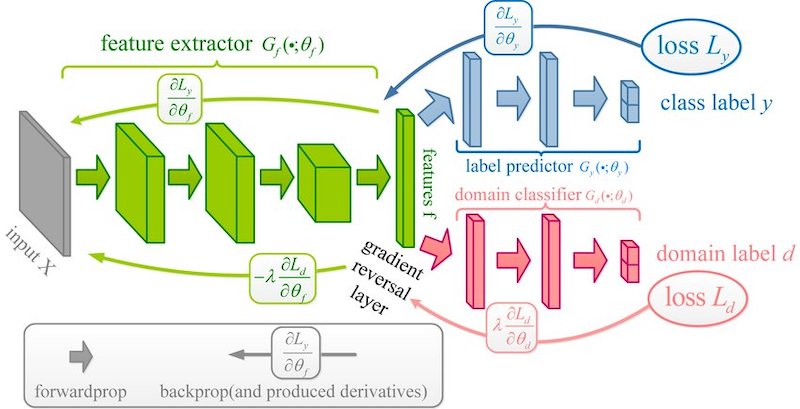

---

<p align = "justify"> ◇ <code><tt><b>DANN</b></tt></code>: our architecture is a modified version of the following <a href="https://github.com/wogong/pytorch-dann" target="_blank">Github</a> code, built on top of a pre-trained <tt><code>ResNet50</tt></code> model, where the last fully connected layer is removed and replaced by a new <tt><code>classifier</tt></code> and a <tt><code>discriminator</tt></code>. The model takes in an input image and applies the ResNet50 features to it, then the features are passed through a <tt><code>bottleneck</tt></code> layer. Its output is passed through a <tt><code>GradientReversal</tt></code> layer, which applies a reverse gradient during backpropagation, before being passed through the classifier and the discriminator. The classifier is a linear layer that predicts the class of the input image, while the discriminator is a multi-layer perceptron that predicts the domain of the input image. The forward method of the class also takes <tt><code>grl_lambda</tt></code> as input which is the hyperparameter used to control the strength of the reverse gradient in the Gradient Reversal layer.

In [ ]:
class DANN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.name = 'DANN'
        backbone = ResNet50(num_classes)
        features = nn.ModuleList(backbone.children())[:-1] # Discard the last layer from ResNet50

        self.features = nn.Sequential(*features)

        self.bottleneck = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256))
        
        self.classifier = nn.Linear(256, num_classes)

        self.discriminator = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 2)) # Binary domain classification

    def forward(self, input, grl_lambda = 1.0):
        x = self.features(input) # Extract features
        features = x.view(x.size(0), -1)
        bottleneck = self.bottleneck(features) # Pass features through bottleneck layer
        
        class_prediction = self.classifier(bottleneck) # Make class predictions

        reverse_bottleneck = GradientReversal.apply(bottleneck, grl_lambda) # Reverse gradients for domain classification        
        domain_prediction = self.discriminator(reverse_bottleneck) # Make domain predictions

        return class_prediction, domain_prediction

#### **Cost function**

<p align = "justify"> ◇ <code><tt><b>DANN_Loss</b></tt></code>: calculates the overall loss for the DANN model as a combination of three different loss terms: <code><tt>classification_loss</tt></code>, a standard cross-entropy loss between the model's output for the source domain and the ground-truth labels for the source domain, <code><tt>source_domain_loss</tt></code>, as a cross-entropy loss between the model's predictions for the source domain and the labels for the source domain (0s), and <code><tt>target_domain_loss</tt></code>, that is the cross-entropy loss between the model's predictions for the target domain and the labels for the target domain (1s). The total loss is the sum of the above three loss terms. This loss function is used to train the DANN model and encourage it to learn a shared feature representation that works well on both the source and target domains and also classify the input data correctly. This approach allows the model to learn a more robust and generalizable feature representation, which is useful when the target domain has limited labeled data, and it can improve the performance on the target domain by using the labeled data from the source domain.




In [ ]:
class DANN_Loss(nn.Module):
    def __init__(self, device = DEVICE):
        super(DANN_Loss, self).__init__()
        self.device = device

    def forward(self, outputs_source, inputs_source, labels_source, domain_prediction_source, domain_prediction_target):

        # Classification loss
        classification_loss = torch.nn.functional.cross_entropy(outputs_source, labels_source)

        # Define labels for the source (0) and target (1) domains
        zeros = torch.zeros(len(inputs_source)).long().to(self.device)
        ones = torch.ones(len(inputs_source)).long().to(self.device)

        # Source domain predictions loss
        source_domain_loss = torch.nn.functional.cross_entropy(domain_prediction_source, zeros)

        # Target domain predictions loss
        target_domain_loss = torch.nn.functional.cross_entropy(domain_prediction_target, ones)

        # Total loss = classification loss + domain classifier loss
        loss = classification_loss + source_domain_loss + target_domain_loss

        return loss

#### **Training step**

<p align = "justify"> ◇ <code><tt><b>training_stepDANN</b></tt></code>: this function is a training step function for the DANN. One importanto point of the function is that for each batch of data, the <code><tt>grl_coefficient</code></tt>, used to control the magnitude of the gradient reversal layer during the forward pass, is computed as follows:

$$λ_p = \frac{2}{1 + e^{-γ⋅p}} - 1 $$

<p align = "justify"> where $p$ is the training progress linearly changing from $0$ to $1$ and $γ$ is set to $10$ (the schedule is not optimized/tweaked). This strategy allows the domain classifier to be less sensitive to noisy signal at the early stages of the training procedure. Then, the network performs two forward passes, one for the source inputs and labels, and another for the target inputs, and calculates the losses using the DANN cost function. The overall loss is then back-propagated through the network to update the parameters using the optimizer.

In [ ]:
def training_stepDANN(net, device, data_loader, optimizer, cost_function, epoch):
  
    samples = 0.
    cumulative_loss = 0.
    cumulative_accuracy = 0.

    # Set the network to training mode
    net.train()

    # Iterate over the training set
    for batch in enumerate(data_loader):
        batch_idx, (inputs_source, labels_source, inputs_target) = batch

        # Load data into device
        inputs_source = inputs_source.to(device)
        inputs_target = inputs_target.to(device)
        labels_source = labels_source.to(device)

        # Reset the optimizer
        optimizer.zero_grad()

        # Compute the GRL parameter
        len_source_loader = len(inputs_source) + len(labels_source)
        grl_coefficient = 2.0 / (1.0 + math.exp(-10 * (float(batch_idx + epoch * len_source_loader) / NUM_EPOCHS / len_source_loader))) - 1

        # Source forward pass
        class_outputs_source, domain_outputs_source = net(inputs_source, grl_coefficient)

        # Target forward pass
        _, domain_outputs_target = net(inputs_target, grl_coefficient)
       
        # Loss computation
        loss = cost_function(class_outputs_source, inputs_source, labels_source, domain_outputs_source, domain_outputs_target)

        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Compute training loss
        samples += inputs_source.shape[0]
        cumulative_loss += loss.item()
        train_loss = cumulative_loss/samples

        # compute training accuracy
        _, predicted = class_outputs_source.max(dim = 1)
        cumulative_accuracy += predicted.eq(labels_source).sum().item()
        train_accuracy = cumulative_accuracy / samples * 100

    return train_loss, train_accuracy

#### **PRODUCT → REAL LIFE**

In [ ]:
DANN = DANN(num_classes = NUM_CLASSES) # Instantiate the DANN model
train_cost_functionDANN = DANN_Loss() # Define the cost function for training as DANN loss
DANN_P_RW_test_loss = []
DANN_P_RW_test_accuracy = []

'''
UDA
Domain Adversarial Neural Network
Product → Real life
Batch sizes: 64(x2), 128
'''

main(
    net = DANN, device = DEVICE, framework = UDA,
    train_batch_size = BATCH_SIZE_64, test_batch_size = BATCH_SIZE_128,
    source_path = PRODUCT_PATH, target_path = REAL_PATH,
    training_step = training_stepDANN, train_cost_function = train_cost_functionDANN,
    test_loss_ = DANN_P_RW_test_loss, test_acc_ = DANN_P_RW_test_accuracy
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Before training:
	 Test loss 0.02343, Test accuracy 3.39
------------------------------------------------------------------


epochs:   7%|▋         | 1/15 [02:15<31:34, 135.30s/it]

	 Epoch: 1
	 Training loss 0.06428, Training accuracy 35.00
	 Test loss 0.01937, Test accuracy 55.73
------------------------------------------------------------------


epochs:  13%|█▎        | 2/15 [04:29<29:12, 134.80s/it]

	 Epoch: 2
	 Training loss 0.04815, Training accuracy 90.81
	 Test loss 0.01384, Test accuracy 75.78
------------------------------------------------------------------


epochs:  20%|██        | 3/15 [06:42<26:44, 133.68s/it]

	 Epoch: 3
	 Training loss 0.03683, Training accuracy 95.69
	 Test loss 0.01027, Test accuracy 82.81
------------------------------------------------------------------


epochs:  27%|██▋       | 4/15 [08:55<24:30, 133.66s/it]

	 Epoch: 4
	 Training loss 0.03050, Training accuracy 97.25
	 Test loss 0.00822, Test accuracy 84.38
------------------------------------------------------------------


epochs:  33%|███▎      | 5/15 [11:10<22:19, 133.94s/it]

	 Epoch: 5
	 Training loss 0.02736, Training accuracy 98.25
	 Test loss 0.00718, Test accuracy 85.16
------------------------------------------------------------------


epochs:  40%|████      | 6/15 [13:24<20:07, 134.12s/it]

	 Epoch: 6
	 Training loss 0.02554, Training accuracy 98.62
	 Test loss 0.00629, Test accuracy 85.16
------------------------------------------------------------------


epochs:  47%|████▋     | 7/15 [15:39<17:54, 134.28s/it]

	 Epoch: 7
	 Training loss 0.02459, Training accuracy 99.44
	 Test loss 0.00582, Test accuracy 85.68
------------------------------------------------------------------


epochs:  53%|█████▎    | 8/15 [17:53<15:39, 134.16s/it]

	 Epoch: 8
	 Training loss 0.02393, Training accuracy 99.75
	 Test loss 0.00548, Test accuracy 85.16
------------------------------------------------------------------


epochs:  60%|██████    | 9/15 [20:06<13:22, 133.82s/it]

	 Epoch: 9
	 Training loss 0.02346, Training accuracy 99.69
	 Test loss 0.00513, Test accuracy 86.46
------------------------------------------------------------------


epochs:  67%|██████▋   | 10/15 [22:20<11:10, 134.03s/it]

	 Epoch: 10
	 Training loss 0.02311, Training accuracy 99.88
	 Test loss 0.00494, Test accuracy 85.94
------------------------------------------------------------------


epochs:  73%|███████▎  | 11/15 [24:34<08:55, 133.84s/it]

	 Epoch: 11
	 Training loss 0.02286, Training accuracy 99.88
	 Test loss 0.00488, Test accuracy 86.72
------------------------------------------------------------------


epochs:  80%|████████  | 12/15 [26:46<06:40, 133.49s/it]

	 Epoch: 12
	 Training loss 0.02274, Training accuracy 99.94
	 Test loss 0.00459, Test accuracy 86.98
------------------------------------------------------------------


epochs:  87%|████████▋ | 13/15 [28:58<04:25, 132.97s/it]

	 Epoch: 13
	 Training loss 0.02254, Training accuracy 99.94
	 Test loss 0.00471, Test accuracy 87.24
------------------------------------------------------------------


epochs:  93%|█████████▎| 14/15 [31:10<02:12, 132.79s/it]

	 Epoch: 14
	 Training loss 0.02250, Training accuracy 100.00
	 Test loss 0.00457, Test accuracy 85.42
------------------------------------------------------------------


epochs: 100%|██████████| 15/15 [33:22<00:00, 133.52s/it]

	 Epoch: 15
	 Training loss 0.02240, Training accuracy 100.00
	 Test loss 0.00447, Test accuracy 85.68
------------------------------------------------------------------
After training:


	 Test loss 0.00448, Test accuracy 85.94
------------------------------------------------------------------


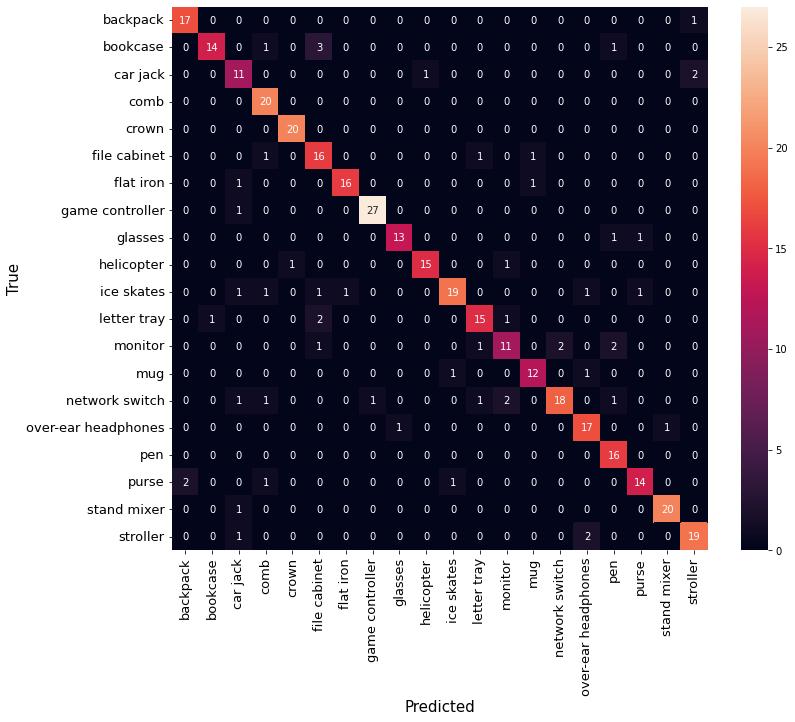

In [ ]:
get_confusion_matrix()

In [ ]:
get_classification_report()

,precision,recall,f1-score,support
backpack,0.894737,0.944444,0.918919,18.000000
bookcase,0.933333,0.736842,0.823529,19.000000
car jack,0.647059,0.785714,0.709677,14.000000
comb,0.800000,1.000000,0.888889,20.000000
crown,0.952381,1.000000,0.975610,20.000000
file cabinet,0.695652,0.842105,0.761905,19.000000
flat iron,0.941176,0.888889,0.914286,18.000000
game controller,0.964286,0.964286,0.964286,28.000000
glasses,0.928571,0.866667,0.896552,15.000000
helicopter,0.937500,0.882353,0.909091,17.000000


#### **REAL LIFE → PRODUCT**

In [ ]:
DANN = DANN(num_classes = NUM_CLASSES) # Instantiate the DANN model
train_cost_functionDANN = DANN_Loss() # Define the cost function for training as DANN loss
DANN_RW_P_test_loss = []
DANN_RW_P_test_accuracy = []

'''
UDA
Domain Adversarial Neural Network
Real life → Product
Batch sizes: 64(x2), 128
'''

main(
    net = DANN, device = DEVICE, framework = UDA,
    train_batch_size = BATCH_SIZE_64, test_batch_size = BATCH_SIZE_128,
    source_path = REAL_PATH, target_path = PRODUCT_PATH,
    training_step = training_stepDANN, train_cost_function = train_cost_functionDANN,
    test_loss_ = DANN_RW_P_test_loss, test_acc_ = DANN_RW_P_test_accuracy
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Before training:
	 Test loss 0.02330, Test accuracy 6.51
------------------------------------------------------------------


epochs:   7%|▋         | 1/15 [02:06<29:36, 126.90s/it]

	 Epoch: 1
	 Training loss 0.06457, Training accuracy 31.87
	 Test loss 0.01813, Test accuracy 68.23
------------------------------------------------------------------


epochs:  13%|█▎        | 2/15 [04:11<27:13, 125.67s/it]

	 Epoch: 2
	 Training loss 0.05220, Training accuracy 79.00
	 Test loss 0.01141, Test accuracy 85.42
------------------------------------------------------------------


epochs:  20%|██        | 3/15 [06:19<25:17, 126.45s/it]

	 Epoch: 3
	 Training loss 0.04169, Training accuracy 88.88
	 Test loss 0.00767, Test accuracy 88.54
------------------------------------------------------------------


epochs:  27%|██▋       | 4/15 [08:25<23:08, 126.25s/it]

	 Epoch: 4
	 Training loss 0.03491, Training accuracy 93.75
	 Test loss 0.00540, Test accuracy 91.15
------------------------------------------------------------------


epochs:  33%|███▎      | 5/15 [10:31<21:02, 126.25s/it]

	 Epoch: 5
	 Training loss 0.03074, Training accuracy 96.06
	 Test loss 0.00416, Test accuracy 93.49
------------------------------------------------------------------


epochs:  40%|████      | 6/15 [12:37<18:57, 126.35s/it]

	 Epoch: 6
	 Training loss 0.02802, Training accuracy 97.50
	 Test loss 0.00337, Test accuracy 94.27
------------------------------------------------------------------


epochs:  47%|████▋     | 7/15 [14:43<16:48, 126.09s/it]

	 Epoch: 7
	 Training loss 0.02631, Training accuracy 98.44
	 Test loss 0.00287, Test accuracy 94.79
------------------------------------------------------------------


epochs:  53%|█████▎    | 8/15 [16:50<14:44, 126.42s/it]

	 Epoch: 8
	 Training loss 0.02502, Training accuracy 99.38
	 Test loss 0.00261, Test accuracy 95.05
------------------------------------------------------------------


epochs:  60%|██████    | 9/15 [18:56<12:37, 126.21s/it]

	 Epoch: 9
	 Training loss 0.02433, Training accuracy 99.31
	 Test loss 0.00227, Test accuracy 94.79
------------------------------------------------------------------


epochs:  67%|██████▋   | 10/15 [21:01<10:28, 125.79s/it]

	 Epoch: 10
	 Training loss 0.02368, Training accuracy 99.94
	 Test loss 0.00219, Test accuracy 94.53
------------------------------------------------------------------


epochs:  73%|███████▎  | 11/15 [23:06<08:22, 125.59s/it]

	 Epoch: 11
	 Training loss 0.02328, Training accuracy 99.94
	 Test loss 0.00201, Test accuracy 95.05
------------------------------------------------------------------


epochs:  80%|████████  | 12/15 [25:11<06:16, 125.37s/it]

	 Epoch: 12
	 Training loss 0.02306, Training accuracy 99.94
	 Test loss 0.00204, Test accuracy 94.01
------------------------------------------------------------------


epochs:  87%|████████▋ | 13/15 [27:18<04:12, 126.02s/it]

	 Epoch: 13
	 Training loss 0.02294, Training accuracy 100.00
	 Test loss 0.00202, Test accuracy 94.27
------------------------------------------------------------------


epochs:  93%|█████████▎| 14/15 [29:26<02:06, 126.44s/it]

	 Epoch: 14
	 Training loss 0.02274, Training accuracy 100.00
	 Test loss 0.00190, Test accuracy 94.53
------------------------------------------------------------------


epochs: 100%|██████████| 15/15 [31:32<00:00, 126.16s/it]

	 Epoch: 15
	 Training loss 0.02257, Training accuracy 100.00
	 Test loss 0.00189, Test accuracy 94.27
------------------------------------------------------------------
After training:


	 Test loss 0.00180, Test accuracy 94.53
------------------------------------------------------------------


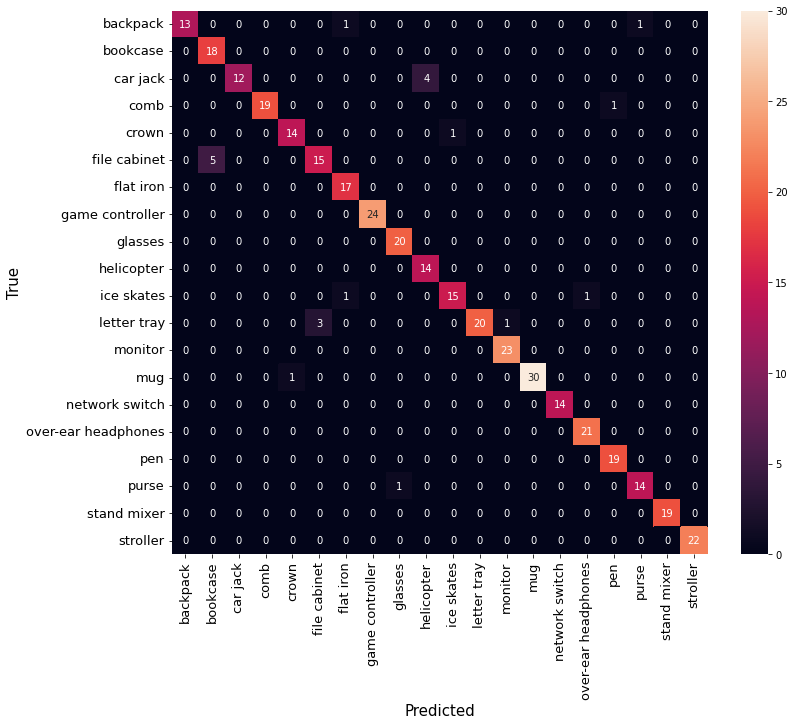

In [ ]:
get_confusion_matrix()

In [ ]:
get_classification_report()

,precision,recall,f1-score,support
backpack,1.000000,0.866667,0.928571,15.000000
bookcase,0.782609,1.000000,0.878049,18.000000
car jack,1.000000,0.750000,0.857143,16.000000
comb,1.000000,0.950000,0.974359,20.000000
crown,0.933333,0.933333,0.933333,15.000000
file cabinet,0.833333,0.750000,0.789474,20.000000
flat iron,0.894737,1.000000,0.944444,17.000000
game controller,1.000000,1.000000,1.000000,24.000000
glasses,0.952381,1.000000,0.975610,20.000000
helicopter,0.777778,1.000000,0.875000,14.000000


### **DSN**

<p align = "justify"> Among the various analyzed reconstruction-based methods, the <b>Domain Separation Network</b> (<b>DSN</b>) provided us the best performance in accordance with our design. Its idea is proposed in "<a href="https://arxiv.org/pdf/1608.06019.pdf" target="_blank">Domain separation networks</a>" by K. Bousmalis, G. Trigeorgis, N. Silberman, D. Krishnan & D. Erhan, <i>Advances in neural information processing systems</i>, 29 (2016).

<p align = "justify"> The aim of this paper is to develop a model that can generalize from a labeled dataset in a source domain to an unlabeled dataset in a target domain. To achieve this, the authors propose this method which ensures that the representations of images from the source domain are similar to those from the target domain. By doing so, the classifier trained on the source domain is able to generalize to the target domain as the input to the classifier is invariant to the domain of origin. The paper also provides a detailed analysis of the DSN method, including an examination of the different cost functions used to train the feature extractor network, as well as a comparison of the feature extractor network with other architectures.

<p align = "justify"> The authors of the paper evaluate the effectiveness of the DSN method on several datasets and tasks such as image classification and semantic segmentation and found that it significantly improves the performance of neural networks when adapting to new domains. They also found that DSN is able to achieve comparable or even better performance than other state-of-the-art domain adaptation methods.

#### **Network**

<p align = "justify"> The DSN paper by Bousmalis et al. (2016) presents a method for training neural networks that can adapt to new domains by using reconstruction-based techniques. This method is based on the idea of separating the features of the input data into two parts: those that are shared across domains (i.e. <b>domain-invariant features</b>), and those that are specific to each domain (i.e. <b>domain-specific features</b>).

<p align = "justify"> The DSN architecture consists of two main components: a <b>feature extractor network</b> and a <b>domain classifier network</b>. The feature extractor network is trained <u>to extract domain-invariant features from the input data</u> and <u>to reconstruct the input data from these features</u>, while the domain classifier network is trained <u>to predict the domain of the input data based on the domain-specific features</u>. The reconstruction loss and the domain classification loss are then combined to form the overall loss function.

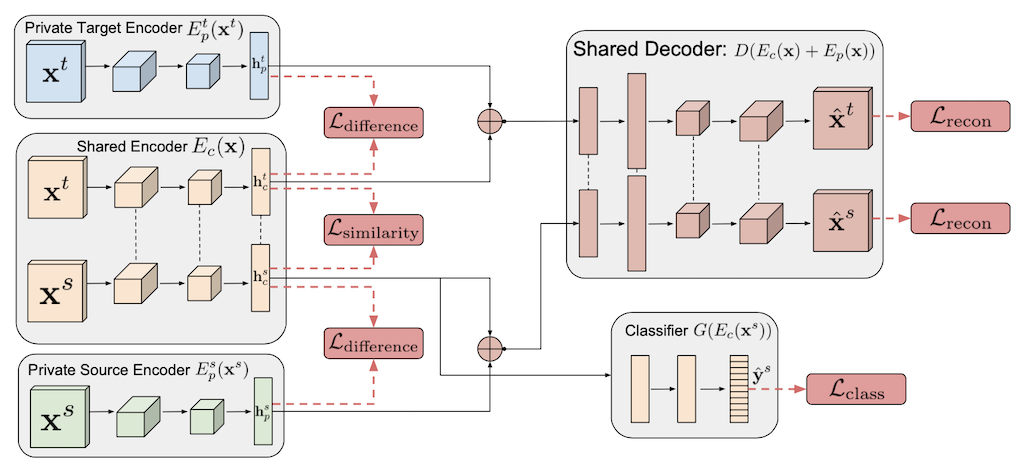

<p align = "justify"> DSNs introduce a novel approach to modeling the representations of different domains by explicitly and jointly identifying both the private and shared components of these representations. The <b>private component is specific to a single domain</b>, while the <b>shared component is common across domains</b>. To achieve this, DSNs employ a loss function that promotes independence between these components. Additionally, a reconstruction loss is added to ensure that the private representations are useful and to improve the generalizability of the model. The result is a model that generates shared representations that are similar across domains and private representations that are distinct. By separating the space in this way, the classifier trained on the shared representations is able to generalize better across domains, as it is not influenced by aspects of the representation that are unique to each domain.

<p align = "justify"> Our model utilizes a private subspace for each domain to capture domain-specific properties, such as background and low-level image statistics. Additionally, it uses a shared subspace, which is enforced through the use of autoencoders and explicit loss functions, to capture representations common across domains. By identifying a shared subspace that is orthogonal to the private subspaces, the DSN is able to differentiate the information that is unique to each domain and produce representations that are more meaningful for the task at hand.

---

<p align = "justify"> Initially, we have defined our shared decoder based on the following code on <a href="https://github.com/RoyalVane/TAF-Cal/blob/80be0251af8a85b56452c69bb7d7f1fcefce6357/src/models/resnet_dec.py" target="_blank">Github</a> by adapting it from ResNet18 to Resnet50, according to our intentions. The shared decoder is a part of the architecture that is used to decode information that is shared across multiple domains. In other words, it is responsible for extracting features that are common to multiple domains and then using those features to generate output. This improves the DSN's ability to generalize to new domains and reduces the need for large amounts of training data, ultimately enhancing the overall performance of the network.

<p align = "justify"> ◇ <code><tt><b>ResizeConv2d</b></tt></code>: combines the functionality of both resizing an image and applying a 2D convolution operation. The forward method is overridden to first resize the input image using the <tt><code>F.interpolate()</tt></code> function with the specified scale factor and mode for increasing or decreasing the spatial resolution of an image, and then the resized image is passed through a 2D convolution operation applying a convolution filter to the image and generating the output.

<p align = "justify"> ◇ <code><tt><b>BasicBlockDecoder</b></tt></code>: defines a basic block structure for our decoder network. In the constructor, the class takes in two arguments: <code><tt>in_planes</tt></code>, the number of channels in the input image, and <code><tt>stride</tt></code>, the factor by which the image will be downscaled. It contains two convolutional layers, two batch normalization layers, and a shortcut connection. The output is passed through a ReLU activation function.

<p align = "justify"> ◇ <code><tt><b>Decoder_Resnet50</b></tt></code>: represents our decoder for DSN model by incapsulating the ResNet50 architecture. This decoder generates images from a latent code, which is a compact representation of the image, indeed the architecture is designed to generate high-resolution images by using a combination of linear and convolutional layers, as well as ResNet blocks which are known to improve the performance of deep neural networks. The architecture is built up by a linear layer, 4 ResNet blocks and a final convolutional layer. The input to each ResNet block is passed through a <code><tt>BasicBlockDecoder</code></tt> and the output is passed to the next ResNet block. The final output is passed through a sigmoid activation function and reshaped.

In [ ]:
class ResizeConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode = "nearest"):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor = self.scale_factor, mode = self.mode) # Resize the input image
        x = self.conv(x) # Apply 2D convolution

        return x


class BasicBlockDecoder(nn.Module):
    def __init__(self, in_planes, stride):
        super().__init__()
        planes = int(in_planes / stride)
        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential(
            ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
            nn.BatchNorm2d(planes))
        
    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x))) # apply ReLU activation on convolutional layer
        out = self.bn1(self.conv1(out))           # apply convolutional and batch normalization layers
        out += self.shortcut(x)                   # add the shortcut connection to the output
        out = torch.relu(out)                     # apply ReLU activation on the final output

        return out


class Decoder_Resnet50(nn.Module):
    def __init__(self, input_channels, num_Blocks = [3, 4, 6, 3], num_channels = 3):
        super().__init__()
        self.in_planes = 1024
        self.linear = nn.Linear(input_channels, 1024)
        # Create 4 layers using the BasicBlockDecoder class with the number of blocks specified and with stride of 2
        self.layer4 = self._make_layer(BasicBlockDecoder, 512, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDecoder, 256, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDecoder, 128, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDecoder, 128, num_Blocks[0], stride=2)
        self.conv1 = ResizeConv2d(64, num_channels, kernel_size=3, scale_factor=3.5)
        
    def _make_layer(self, BasicBlockDecoder, planes, num_Blocks, stride):
        strides = [stride] + [1] * (num_Blocks - 1) # Create strides for each block
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDecoder(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, input):
        x = self.linear(input)                  # Pass input through linear layer
        x = x.view(input.size(0), 1024, 1, 1)   # Reshape input
        x = F.interpolate(x, scale_factor = 4)  # Interpolate input
        x = self.layer4(x)                      # Pass input through each layer
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = torch.sigmoid(self.conv1(x))        # Apply sigmoid activation
        output = x.view(x.size(0), 3, 224, 224) # Reshape output

        return output

<p align = "justify"> ◇ <code><tt><b>DSN</b></tt></code>: is a neural network class that is built on top of a pre-trained ResNet50 model. The class contains several sub-modules, including a <b>shared encoder</b>, a <b>bottleneck</b> layer, a <b>classifier</b>, a <b>domain adversarial network</b>, a <b>source encoder</b>, a <b>target encoder</b>, a <b>feature merge module</b>, and a <b>shared decoder</b>. The <u>shared encoder, source encoder and target encoder are all ResNet50 models</u>. The shared encoder is used to extract features from the input data that are then used by the classifier and domain adversarial network. The classifier is a simple linear layer that maps the features to the specified number of classes. The domain adversarial network is a multi-layer perceptron that is trained to predict the domain of the input data. The private code (either <code><tt>source_encoder</code></tt> or <code><tt>target_encoder</code></tt>), shared code (<code><tt>shared_encoder</code></tt>) and union code (<code><tt>merge_features</code></tt>) are the outputs of the private encoder (depending on the parameter <code><tt>code</tt></code>), shared encoder and merge feature layers respectively. The shared decoder is used to reconstruct the image from union code. The forward method takes in input data, a mode (either 'source' or 'target'), a reconstruction scheme (either 'private', 'all' or 'share') and a <code><tt>grl_lambda</code></tt> (the hyperparameter λ for gradient reversal layer). Depending on the mode and reconstruction scheme, the forward method applies the appropriate encoders, merges the features and applies the shared decoder. The outputs are: <code><tt>class_prediction</code></tt> (predicted class of the input data), <code><tt>domain_prediction</code></tt> (predicted domain), <code><tt>private_representation</code></tt> (private feature representation) and <code><tt>shared_representation</code></tt> (shared feature representation). All these values are the intermediate outputs that we use for evaluation and analysis, while <code><tt>reconstruction_output</code></tt> (reconstructed input from the merge features) represents the final output of the model.

In [ ]:
class DSN(nn.Module):
    def __init__(self, num_classes):   
        super(DSN, self).__init__()
        self.name = 'DSN'

        ### BACKBONE ###
        backbone = ResNet50(num_classes)
        features = nn.ModuleList(backbone.children())[:-1]

        ### SHARED ENCODER ###
        self.shared_encoder = nn.Sequential(*features)

        ### BOTTLENECK ###
        self.bottleneck = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True))
        
        ### CLASSIFIER ###
        self.classifier = nn.Sequential(nn.Linear(512, num_classes))

        ### DOMAIN ADVERSARIAL NETWORK ###
        self.domain_adversarial_network = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 2))
        
        ### PRIVATE SOURCE ENCODER ###
        self.source_encoder = nn.Sequential(*features)

        ### PRIVATE TARGET ENCODER ###
        self.target_encoder = nn.Sequential(*features)

        ### SHARED DECODER ###
        self.merge_features = nn.Sequential(nn.Linear(4096, 512), nn.ReLU(inplace=True))
        self.shared_decoder = nn.Sequential(Decoder_Resnet50(input_channels = 512))

        # Initialize the weight and bias of the bottleneck, classifier and domain adversarial network
        modules_to_initialize = [self.bottleneck, self.classifier, self.domain_adversarial_network]
        for module in modules_to_initialize:
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight.data)
                if m.bias is not None:
                    nn.init.constant_(module.bias.data, 0)

    def forward(self, input_data, mode, reconstruction_scheme, grl_lambda = 0.0):
        shared_representation = self.shared_encoder(input_data) # Encode the input inside the shared encoder
        shared_representation = shared_representation.view(shared_representation.size(0), -1) # Flatten the output
        bottleneck_output = self.bottleneck(shared_representation) # Apply the bottleneck layer

        class_prediction = self.classifier(bottleneck_output) # Use the classifier to predict the class
        reversed_shared_representation = GradientReversal.apply(bottleneck_output, grl_lambda) # Apply the reverse layer function
        domain_prediction = self.domain_adversarial_network(reversed_shared_representation) # Use the domain adversarial network to predict the domain

        # Encode the input data using the source or target encoder based on the mode
        if mode == 'source':
            private_representation = self.source_encoder(input_data)
        elif mode == 'target':
            private_representation = self.target_encoder(input_data)
        private_representation = private_representation.view(private_representation.size(0), -1) # Flatten the output

        # Merge the shared and private representations based on the reconstruction scheme
        if reconstruction_scheme == 'private':
            union_representation = self.merge_features(torch.cat((private_representation, private_representation), 1))
        elif reconstruction_scheme == 'all':
            union_representation = self.merge_features(torch.cat((shared_representation, private_representation), 1))
        elif reconstruction_scheme == 'shared':
            union_representation = self.merge_features(torch.cat((shared_representation, shared_representation), 1))

        # Use the shared decoder to reconstruct the input
        reconstruction_output = self.shared_decoder(union_representation)

        return class_prediction, domain_prediction, private_representation, shared_representation, reconstruction_output

#### **Cost function**

<p align = "justify">The goal of training is to minimize the following loss with respect to parameters $Θ = \{θ_c, θ_p, θ_d, θ_g\}$ (where $θ_{c}$ represents features that are shared across domains, $θ_{p}$ represents features that are private to each domain, $θ_{d}$ represents features of an image reconstruction and $θ_{g}$ represents features of task-specific predictions):

$$ ℒ = ℒ_{CLASSIFICATION} + α ⋅ ℒ_{RECONSTRUCTION} + β ⋅ ℒ_{DIFFERENCE} + γ ⋅ ℒ_{SIMILARITY}$$
where:
- $α, β$ and $γ$ are weights that control the interaction of the loss terms;
- <p align = "justify">$ℒ_{CLASSIFICATION}$ trains the model to <b>predict the output labels</b> and it is applied <u>only to the source domain</u> because we assume the target domain is unlabeled;
- <p align = "justify">$ℒ_{RECONSTRUCTION}$ can be seen as a combination of two losses which are applied to both domains:
<ul>
  <li> <p align = "justify">a <b>Mean Squared Error</b> (<b>MSE</b>) term which measures the average squared difference between the predicted and real values. It is computed by taking the <u>sum of the squared differences between the predicted and real values, divided by the number of elements in the data</u>;</li>
  <li> <p align = "justify">a <b>Scale–Invariant Mean Squared Error</b> (<b>SIMSE</b>) term that is scaled by the total number of elements in the data squared. It is computed by taking the <u>sum of the squared differences between the predicted and real values, divided by the number of elements in the data squared</u>.</li>
</ul>
$$ ℒ_{RECONSTRUCTION} = \sum_{i=1}^{N_{s}}{ℒ_{MSE}(x_i^s, \bar{x}_i^s)} + \sum_{i=1}^{N_{t}}{ℒ_{MSE}(x_i^t, \bar{x}_i^t)} + \sum_{i=1}^{N_{s}}{ℒ_{SIMSE}(x_i^s, \bar{x}_i^s)} + \sum_{i=1}^{N_{t}}{ℒ_{SIMSE}(x_i^t, \bar{x}_i^t)}$$
- <p align = "justify">$ℒ_{DIFFERENCE}$ is applied to both domains and <b>encourages the shared and private encoders to encode different aspects of the inputs</b>. We define the loss via a soft subspace orthogonality constraint between the private and shared representation of each domain. It is computed by <u>normalizing the inputs with L2 normalization, calculating the dot product between the normalized inputs, and then taking the mean of the squared dot produc</u>t.
- <p align = "justify">$ℒ_{SIMILARITY}$ is used to train a model to <b>produce representations such that a classifier cannot reliably predict the domain of the encoded representation</b>. Maximizing such “confusion” is achieved via a <u>Gradient Reversal Layer</u> (GRL) and a domain classifier trained to predict the domain producing the hidden representation. Essentially, <u>we maximize the binomial cross–entropy for the domain prediction task with respect to $θ_z$</u> (which maps a shared representation vector to a prediction of the label $\bar{d}$), <u>while minimizing it with respect to $θ_c$</u>:
$$\begin{equation} ℒ_{SIMILARITY} = \sum_{i=0}^{N_{s}+N_{t}} \Big \{ d_i log \bar{d}_i + (1-d_i)log(1-\bar{d}_i) \Big \}
\end{equation} $$

---
<p align = "justify">In a nutshell, in DSN these cost functions are used to train the feature extractor network by minimizing the reconstruction loss, which is the combination of the <code><tt>MSE</code></tt>, <code><tt>SIMSE</code></tt>, and <code><tt>DiffLoss</code></tt> cost functions. The domain classifier network is trained to predict the domain of the input data by minimizing the domain classification loss, which is a cross-entropy loss.

In [ ]:
class MSE(nn.Module):
    def __init__(self):
        super(MSE, self).__init__()

    def forward(self, pred, real):
        diffs = torch.add(real, -pred)
        n = torch.numel(diffs.data)
        # Mean Squared Error
        mse = torch.sum(diffs.pow(2)) / n

        return mse


class SIMSE(nn.Module):
    def __init__(self):
        super(SIMSE, self).__init__()

    def forward(self, pred, real):
        diffs = torch.add(real, -pred)
        n = torch.numel(diffs.data)
        # Squared sum of the differences
        simse = torch.sum(diffs).pow(2) / (n**2)

        return simse


class DiffLoss(nn.Module):
    def __init__(self):
        super(DiffLoss, self).__init__()

    def forward(self, input1, input2):
        batch_size = input1.size(0)
        # Reshape the input tensors to 1D vectors
        input_1 = input1.view(batch_size, -1)
        input_2 = input2.view(batch_size, -1)

        # L2 norm of the inputs
        input1_l2_norm = torch.norm(input_1, p=2, dim=1, keepdim=True).detach()
        input2_l2_norm = torch.norm(input_2, p=2, dim=1, keepdim=True).detach()

        # Normalize the inputs
        input1_l2 = input1.div(input1_l2_norm.expand_as(input1) + 1e-6)
        input2_l2 = input2.div(input2_l2_norm.expand_as(input_2) + 1e-6)

        # Mean squared difference between the normalized inputs
        diff_loss = torch.mean((input1_l2.t().mm(input2_l2)).pow(2))
        
        return diff_loss

<p align = "justify"> ◇ <code><tt><b>DSN_Loss</b></tt></code>: represents a custom loss function for our Domain Separation Network. This class can be used to calculate the total loss for training the model, by combining different previously created losses (<tt><code>MSE</tt></code>, <tt><code>SIMSE</tt></code>, and <tt><code>DiffLoss</tt></code>) that measure the similarity and dissimilarity between the source and target domains, the reconstruction error and the shared feature space.

In [ ]:
class DSN_Loss(nn.Module):
    def __init__(self, alpha_weight = 0.01, beta_weight = 0.075):
        super(DSN_Loss, self).__init__()
        self.alpha_weight = alpha_weight
        self.beta_weight = beta_weight
        self.MSE = MSE()
        self.SIMSE = SIMSE()
        self.DiffLoss = DiffLoss()

    def forward(self, inputs_source, inputs_target, 
                      source_private_representation, source_shared_representation, source_reconstruction_representation, 
                      target_private_representation, target_shared_representation, target_reconstruction_representation):

        # Loss on the source
        input_img = inputs_source.clone().detach()
        source_MSE = self.alpha_weight * self.MSE(source_reconstruction_representation, input_img)
        source_SIMSE = self.alpha_weight * self.SIMSE(source_reconstruction_representation, input_img)
        source_DIFFERENCE = self.beta_weight * self.DiffLoss(source_private_representation, source_shared_representation)
        loss = source_MSE + source_SIMSE + source_DIFFERENCE

        # Loss on target
        target_MSE = self.alpha_weight * self.MSE(target_reconstruction_representation, inputs_target)
        target_SIMSE = self.alpha_weight * self.SIMSE(target_reconstruction_representation, inputs_target)
        target_DIFFERENCE = self.beta_weight * self.DiffLoss(target_private_representation, target_shared_representation)
        loss += target_MSE + target_SIMSE + target_DIFFERENCE

        return loss

#### **Training step**

<p align = "justify"> ◇ <code><tt><b>training_stepDSN</b></tt></code>: defines a training step whose core is the if-else branch used to determine whether to include the similarity loss term in the overall loss that is used to update the model's parameters. When the current step of the training process is greater than a specified threshold (<code><tt>active_domain_loss_step</tt></code>), the function calculates the weight <code><tt>grl_lambda</code></tt> that is used to adjust the gradient reversal layer. It then performs two forward passes on the model, one on the source data and one on the target data, using the  <code><tt>mode</code></tt> and <code><tt>reconstruction_scheme</code></tt> parameters to specify the type of forward pass. The function also calculates two similarity losses for both domains using the cross-entropy loss. The similarity losses are used to train the model to be domain-invariant. On the other hand, the function performs two forward passes on the model, one on the source data and one on the target data, without calculating the similarity losses. This means that the model is not trained on domain-invariance in this phase of the training process. After the forward passes, the function calculates the classification loss using the cross-entropy loss and the DSN loss using the specified cost function. The function also calculates and keeps track of the training loss and accuracy for each batch, and returns the updated model.

<p align = "justify"> <sub><b>Note:</b> the purpose of including the similarity loss term in the later stages of the training process is to make the model more robust to differences between the source and target domains. This is known as <b>domain-invariance</b>. In domain adaptation, the goal is to train a model on a labeled source dataset and then use it to make predictions on an unlabeled target dataset. However, the source and target datasets may have different distributions, which can make the model perform poorly on the target dataset. By adding the similarity loss term in the later stages of the training process, the model is encouraged to learn feature representations that are invariant to the domain shift, which helps it to generalize better to the target dataset. Additionally, the <code><tt>GRL_lambda</code></tt> is a weighting parameter used to control the strength of the gradient reversal layer, which is used to create the domain-invariant representations. At the early stage of the training process, it's set to zero, meaning that the model is trained normally. As the training process progresses, the value of <code><tt>GRL_lambda</code></tt> increases, encouraging the model to learn domain-invariant representations.</sub>

In [ ]:
def training_stepDSN(net, device, data_loader, optimizer, cost_function, epoch):

    samples = 0.
    cumulative_loss = 0.
    cumulative_accuracy = 0.

    current_step = 0
    active_domain_loss_step = 20
    
    gamma_weight = 0.25

    # Set the network to training mode
    net.train()

    # Iterate over the training set
    for batch in enumerate(data_loader):
        batch_idx, (inputs_source, labels_source, inputs_target) = batch

        # Load data into device
        inputs_source = inputs_source.to(device)
        labels_source = labels_source.to(device)
        inputs_target = inputs_target.to(device)

        # Reset the optimizer
        optimizer.zero_grad()
        loss = 0

        # Forward pass
        if current_step > active_domain_loss_step:
            # Training progress and GRL lambda computation
            len_source_loader = len(inputs_source) + len(labels_source)
            grl_coefficient = 2.0 / (1.0 + np.exp(-10 * (float(batch_idx + epoch * len_source_loader / NUM_EPOCHS / len_source_loader)))) - 1

            # Source prediction
            (outputs, 
             source_domain_prediction, 
             source_private_representation, 
             source_shared_representation, 
             source_reconstruction_representation) = net(inputs_source, mode = 'source', reconstruction_scheme = 'all', grl_lambda = grl_coefficient)

            # Target prediction
            (_, 
             target_domain_prediction, 
             target_private_representation, 
             target_shared_representation, 
             target_reconstruction_representation) = net(inputs_target, mode = 'target', reconstruction_scheme = 'all', grl_lambda = grl_coefficient)

            source_domain_label = torch.zeros(len(inputs_source), dtype=torch.long).to(device)
            target_domain_label = torch.ones(len(inputs_source), dtype=torch.long).to(device)

            # Similarity loss
            loss_source_SIMILARITY = gamma_weight * torch.nn.functional.cross_entropy(source_domain_prediction, source_domain_label)
            loss_target_SIMILARITY = gamma_weight * torch.nn.functional.cross_entropy(target_domain_prediction, target_domain_label)
            
            loss += loss_source_SIMILARITY + loss_target_SIMILARITY
        
        else:
            # Source prediction
            (outputs, 
             source_domain_prediction, 
             source_private_representation, 
             source_shared_representation, 
             source_reconstruction_representation) = net(inputs_source, mode = 'source', reconstruction_scheme = 'all')

            # Target prediction
            (_, 
             target_domain_prediction, 
             target_private_representation, 
             target_shared_representation, 
             target_reconstruction_representation) = net(inputs_target, mode = 'target', reconstruction_scheme = 'all')

        # Classification loss
        loss += torch.nn.functional.cross_entropy(outputs, labels_source)

        # DSN loss
        loss += cost_function(inputs_source, inputs_target,
                             source_private_representation, source_shared_representation, source_reconstruction_representation, 
                             target_private_representation, target_shared_representation, target_reconstruction_representation)

        # Update current step
        current_step += 1

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Compute training loss
        samples += inputs_source.shape[0]
        cumulative_loss += loss.item()
        train_loss = cumulative_loss/samples

        # Compute training accuracy
        _, predicted = outputs.max(dim = 1)
        cumulative_accuracy += predicted.eq(labels_source).sum().item()
        train_accuracy = cumulative_accuracy / samples * 100

    return train_loss, train_accuracy

#### **PRODUCT → REAL LIFE**

In [ ]:
DSN = DSN(num_classes = NUM_CLASSES) # Instantiate the DSN model
train_cost_functionDSN = DSN_Loss() # Define the cost function for training as DSN loss
DSN_P_RW_test_loss = []
DSN_P_RW_test_accuracy = []

'''
UDA
Domain Separation Network
Product → Real life
Batch sizes: 16(x2), 128
'''

main(
    net = DSN, device = DEVICE, framework = UDA,
    train_batch_size = BATCH_SIZE_16, test_batch_size = BATCH_SIZE_128,
    source_path = PRODUCT_PATH, target_path = REAL_PATH,
    training_step = training_stepDSN, train_cost_function = train_cost_functionDSN,
    test_loss_ = DSN_P_RW_test_loss, test_acc_ = DSN_P_RW_test_accuracy
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Before training:
	 Test loss 0.02345, Test accuracy 8.33
------------------------------------------------------------------


epochs:   7%|▋         | 1/15 [03:25<47:58, 205.62s/it]

	 Epoch: 1
	 Training loss 0.18157, Training accuracy 43.94
	 Test loss 0.01606, Test accuracy 73.70
------------------------------------------------------------------


epochs:  13%|█▎        | 2/15 [06:50<44:28, 205.28s/it]

	 Epoch: 2
	 Training loss 0.08432, Training accuracy 89.75
	 Test loss 0.00625, Test accuracy 84.64
------------------------------------------------------------------


epochs:  20%|██        | 3/15 [10:18<41:17, 206.42s/it]

	 Epoch: 3
	 Training loss 0.04085, Training accuracy 95.62
	 Test loss 0.00433, Test accuracy 87.24
------------------------------------------------------------------


epochs:  27%|██▋       | 4/15 [13:44<37:50, 206.42s/it]

	 Epoch: 4
	 Training loss 0.03180, Training accuracy 97.12
	 Test loss 0.00405, Test accuracy 88.02
------------------------------------------------------------------


epochs:  33%|███▎      | 5/15 [17:10<34:22, 206.26s/it]

	 Epoch: 5
	 Training loss 0.02647, Training accuracy 98.75
	 Test loss 0.00336, Test accuracy 87.76
------------------------------------------------------------------


epochs:  40%|████      | 6/15 [20:36<30:55, 206.12s/it]

	 Epoch: 6
	 Training loss 0.02478, Training accuracy 99.31
	 Test loss 0.00321, Test accuracy 87.76
------------------------------------------------------------------


epochs:  47%|████▋     | 7/15 [24:01<27:26, 205.84s/it]

	 Epoch: 7
	 Training loss 0.02344, Training accuracy 99.38
	 Test loss 0.00320, Test accuracy 88.54
------------------------------------------------------------------


epochs:  53%|█████▎    | 8/15 [27:28<24:02, 206.03s/it]

	 Epoch: 8
	 Training loss 0.02333, Training accuracy 99.75
	 Test loss 0.00292, Test accuracy 90.10
------------------------------------------------------------------


epochs:  60%|██████    | 9/15 [30:54<20:35, 206.00s/it]

	 Epoch: 9
	 Training loss 0.02230, Training accuracy 99.75
	 Test loss 0.00295, Test accuracy 90.36
------------------------------------------------------------------


epochs:  67%|██████▋   | 10/15 [34:19<17:08, 205.73s/it]

	 Epoch: 10
	 Training loss 0.02185, Training accuracy 99.94
	 Test loss 0.00273, Test accuracy 90.62
------------------------------------------------------------------


epochs:  73%|███████▎  | 11/15 [37:44<13:42, 205.62s/it]

	 Epoch: 11
	 Training loss 0.02174, Training accuracy 99.75
	 Test loss 0.00320, Test accuracy 88.80
------------------------------------------------------------------


epochs:  80%|████████  | 12/15 [41:10<10:16, 205.50s/it]

	 Epoch: 12
	 Training loss 0.02151, Training accuracy 99.94
	 Test loss 0.00314, Test accuracy 88.80
------------------------------------------------------------------


epochs:  87%|████████▋ | 13/15 [44:35<06:51, 205.51s/it]

	 Epoch: 13
	 Training loss 0.02138, Training accuracy 100.00
	 Test loss 0.00284, Test accuracy 89.58
------------------------------------------------------------------


epochs:  93%|█████████▎| 14/15 [48:01<03:25, 205.56s/it]

	 Epoch: 14
	 Training loss 0.02117, Training accuracy 99.94
	 Test loss 0.00275, Test accuracy 90.10
------------------------------------------------------------------


epochs: 100%|██████████| 15/15 [51:28<00:00, 205.87s/it]

	 Epoch: 15
	 Training loss 0.02113, Training accuracy 99.75
	 Test loss 0.00292, Test accuracy 89.06
------------------------------------------------------------------
After training:


	 Test loss 0.00292, Test accuracy 89.32
------------------------------------------------------------------


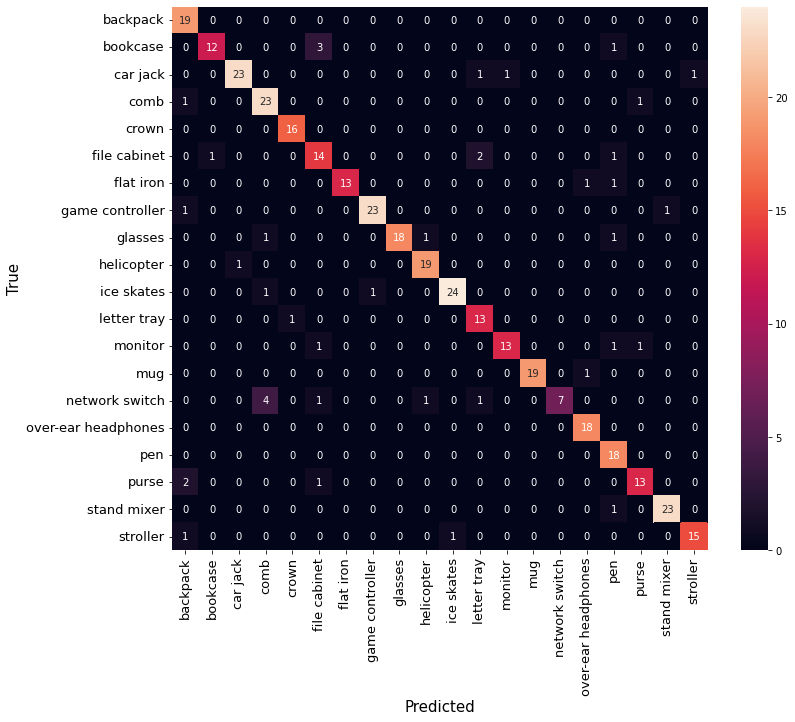

In [ ]:
get_confusion_matrix()

In [ ]:
get_classification_report()

,precision,recall,f1-score,support
backpack,0.791667,1.000000,0.883721,19.000000
bookcase,0.923077,0.750000,0.827586,16.000000
car jack,0.958333,0.884615,0.920000,26.000000
comb,0.793103,0.920000,0.851852,25.000000
crown,0.941176,1.000000,0.969697,16.000000
file cabinet,0.700000,0.777778,0.736842,18.000000
flat iron,1.000000,0.866667,0.928571,15.000000
game controller,0.958333,0.920000,0.938776,25.000000
glasses,1.000000,0.857143,0.923077,21.000000
helicopter,0.904762,0.950000,0.926829,20.000000


#### **REAL LIFE → PRODUCT**

In [ ]:
DSN = DSN(num_classes = NUM_CLASSES) # Instantiate the DSN model
train_cost_functionDSN = DSN_Loss() # Define the cost function for training as DSN loss
DSN_RW_P_test_loss = []
DSN_RW_P_test_accuracy = []

'''
UDA
Domain Separation Network
Real life → Product
Batch sizes: 16(x2), 128
'''

main(
    net = DSN, device = DEVICE, framework = UDA,
    train_batch_size = BATCH_SIZE_16, test_batch_size = BATCH_SIZE_128,
    source_path = REAL_PATH, target_path = PRODUCT_PATH,
    training_step = training_stepDSN, train_cost_function = train_cost_functionDSN,
    test_loss_ = DSN_RW_P_test_loss, test_acc_ = DSN_RW_P_test_accuracy
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Before training:
	 Test loss 0.02359, Test accuracy 4.95
------------------------------------------------------------------


epochs:   7%|▋         | 1/15 [03:20<46:53, 201.00s/it]

	 Epoch: 1
	 Training loss 0.18828, Training accuracy 39.06
	 Test loss 0.01603, Test accuracy 75.26
------------------------------------------------------------------


epochs:  13%|█▎        | 2/15 [06:44<43:52, 202.49s/it]

	 Epoch: 2
	 Training loss 0.10953, Training accuracy 77.62
	 Test loss 0.00495, Test accuracy 88.28
------------------------------------------------------------------


epochs:  20%|██        | 3/15 [10:10<40:50, 204.22s/it]

	 Epoch: 3
	 Training loss 0.05601, Training accuracy 90.44
	 Test loss 0.00253, Test accuracy 92.45
------------------------------------------------------------------


epochs:  27%|██▋       | 4/15 [13:37<37:37, 205.18s/it]

	 Epoch: 4
	 Training loss 0.04009, Training accuracy 94.81
	 Test loss 0.00202, Test accuracy 92.97
------------------------------------------------------------------


epochs:  33%|███▎      | 5/15 [17:03<34:15, 205.53s/it]

	 Epoch: 5
	 Training loss 0.03179, Training accuracy 96.81
	 Test loss 0.00177, Test accuracy 94.53
------------------------------------------------------------------


epochs:  40%|████      | 6/15 [20:30<30:52, 205.87s/it]

	 Epoch: 6
	 Training loss 0.02713, Training accuracy 98.44
	 Test loss 0.00169, Test accuracy 94.79
------------------------------------------------------------------


epochs:  47%|████▋     | 7/15 [23:57<27:29, 206.21s/it]

	 Epoch: 7
	 Training loss 0.02635, Training accuracy 98.50
	 Test loss 0.00171, Test accuracy 93.23
------------------------------------------------------------------


epochs:  53%|█████▎    | 8/15 [27:22<24:02, 206.12s/it]

	 Epoch: 8
	 Training loss 0.02366, Training accuracy 99.69
	 Test loss 0.00185, Test accuracy 93.49
------------------------------------------------------------------


epochs:  60%|██████    | 9/15 [30:49<20:37, 206.23s/it]

	 Epoch: 9
	 Training loss 0.02371, Training accuracy 99.56
	 Test loss 0.00169, Test accuracy 94.27
------------------------------------------------------------------


epochs:  67%|██████▋   | 10/15 [34:17<17:14, 206.92s/it]

	 Epoch: 10
	 Training loss 0.02314, Training accuracy 99.56
	 Test loss 0.00172, Test accuracy 94.79
------------------------------------------------------------------


epochs:  73%|███████▎  | 11/15 [37:58<14:04, 211.11s/it]

	 Epoch: 11
	 Training loss 0.02197, Training accuracy 100.00
	 Test loss 0.00193, Test accuracy 94.01
------------------------------------------------------------------


epochs:  80%|████████  | 12/15 [41:42<10:44, 214.96s/it]

	 Epoch: 12
	 Training loss 0.02203, Training accuracy 99.88
	 Test loss 0.00184, Test accuracy 94.79
------------------------------------------------------------------


epochs:  87%|████████▋ | 13/15 [45:07<07:04, 212.02s/it]

	 Epoch: 13
	 Training loss 0.02163, Training accuracy 99.88
	 Test loss 0.00176, Test accuracy 95.05
------------------------------------------------------------------


epochs:  93%|█████████▎| 14/15 [48:32<03:29, 209.93s/it]

	 Epoch: 14
	 Training loss 0.02144, Training accuracy 100.00
	 Test loss 0.00184, Test accuracy 95.31
------------------------------------------------------------------


epochs: 100%|██████████| 15/15 [52:12<00:00, 208.81s/it]

	 Epoch: 15
	 Training loss 0.02143, Training accuracy 99.88
	 Test loss 0.00191, Test accuracy 93.75
------------------------------------------------------------------
After training:


	 Test loss 0.00185, Test accuracy 94.01
------------------------------------------------------------------


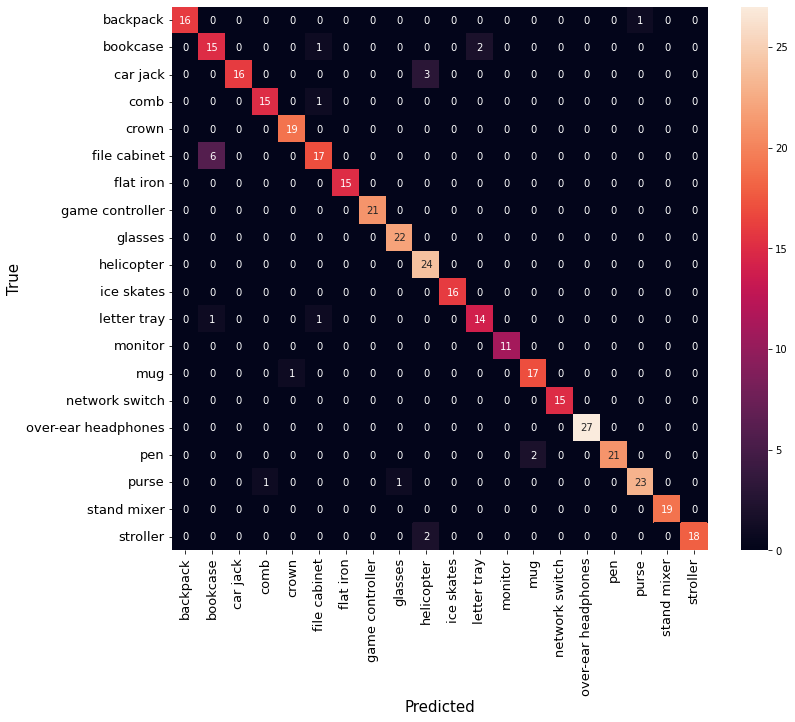

In [ ]:
get_confusion_matrix()

In [ ]:
get_classification_report()

,precision,recall,f1-score,support
backpack,1.000000,0.941176,0.969697,17.000000
bookcase,0.681818,0.833333,0.750000,18.000000
car jack,1.000000,0.842105,0.914286,19.000000
comb,0.937500,0.937500,0.937500,16.000000
crown,0.950000,1.000000,0.974359,19.000000
file cabinet,0.850000,0.739130,0.790698,23.000000
flat iron,1.000000,1.000000,1.000000,15.000000
game controller,1.000000,1.000000,1.000000,21.000000
glasses,0.956522,1.000000,0.977778,22.000000
helicopter,0.827586,1.000000,0.905660,24.000000


## **RESULTS**

In the following table we can see the comparison of the test accuracy between the <u>architectures</u>:
- ResNet18,
- ResNet34,
- **ResNet50**,
- ResNet101,
- ResNet152,

using dataloaders corresponding to two different <u>frameworks</u>:
- **Baseline**,
- **Upperbound**,

training and testing in two opposite <u>directions</u>:
- *Product → Real Life*,
- *Product ← Real Life*.


<table>
  <tr>
    <td>
      <table>
        <caption><font size="4"><b><font color='black'>Baseline</caption>
        <tr>
          <th><center><font size="4"><font color='grey'>Network</th>
          <th><center><font size="4"><font color='grey'>P → RW</th>
          <th><center><font size="4"><font color='grey'>RW → P</th>
          <th><center><font size="4"><font color='grey'>Train/Test batch</th>
        </tr>
        <tr>
          <td><center><font size="3"><font color='red'><b>ResNet18</td>
          <td><center><font size="3"><font color='goldenrod'><b>73.18%</td>
          <td><center><font size="3"><font color='limegreen'><b>90.62%</td>
          <td><center><font size="3"><font color='deepskyblue'><b>128, 128</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='red'><b>ResNet34</td>
          <td><center><font size="3"><font color='goldenrod'><b>77.08%</td>
          <td><center><font size="3"><font color='limegreen'><b>89.58%</td>
          <td><center><font size="3"><font color='deepskyblue'><b>128, 128</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='red'><b>ResNet50</td>
          <td><center><font size="3"><font color='goldenrod'><b>83.85%</td>
          <td><center><font size="3"><font color='limegreen'><b>92.19%</td>
          <td><center><font size="3"><font color='deepskyblue'><b>128, 128</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='red'><b>ResNet101</td>
          <td><center><font size="3"><font color='goldenrod'><b>85.42%</td>
          <td><center><font size="3"><font color='limegreen'><b>95.05%</td>
          <td><center><font size="3"><font color='deepskyblue'><b>64, 128</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='red'><b>ResNet152</td>
          <td><center><font size="3"><font color='goldenrod'><b>85.16%</td>
          <td><center><font size="3"><font color='limegreen'><b>93.49%</td>
          <td><center><font size="3"><font color='deepskyblue'><b>64, 64</td>
        </tr>
      </table>
    </td>
    <td>
      <table>
        <caption><font size="4"><b><font color='black'>Upperbound</caption>
        <tr>
          <th><center><font size="4"><font color='grey'>Network</th>
          <th><center><font size="4"><font color='grey'>P → RW</th>
          <th><center><font size="4"><font color='grey'>RW → P</th>
          <th><center><font size="4"><font color='grey'>Train/Test batch</tr>
        <tr>
          <td><center><font size="3"><font color='red'><b>ResNet18</td>
          <td><center><font size="3"><font color='goldenrod'><b>90.10%</td>
          <td><center><font size="3"><font color='limegreen'><b>93.75%</td>
          <td><center><font size="3"><font color='deepskyblue'><b>128, 128</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='red'><b>ResNet34</td>
          <td><center><font size="3"><font color='goldenrod'><b>91.67%</td>
          <td><center><font size="3"><font color='limegreen'><b>96.80%</td>
          <td><center><font size="3"><font color='deepskyblue'><b>128, 128</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='red'><b>ResNet50</td>
          <td><center><font size="3"><font color='goldenrod'><b>92.71%</td>
          <td><center><font size="3"><font color='limegreen'><b>97.14%</td>
          <td><center><font size="3"><font color='deepskyblue'><b>128, 128</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='red'><b>ResNet101</td>
          <td><center><font size="3"><font color='goldenrod'><b>94.01%</td>
          <td><center><font size="3"><font color='limegreen'><b>96.88%</td>
          <td><center><font size="3"><font color='deepskyblue'><b>64, 128</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='red'><b>ResNet152</td>
          <td><center><font size="3"><font color='goldenrod'><b>96.09%</td>
          <td><center><font size="3"><font color='limegreen'><b>97.66%</td>
          <td><center><font size="3"><font color='deepskyblue'><b>64, 64</td>
        </tr>
      </table>
    </td>
  </tr>
</table>

<p align = "justify"> As mentioned above, we decided to focus on ResNet50 and use it as a feature extractor or backbone depending on the models we have implemented. We expected that the proposed <b>Domain Adaptation techniques would perform better than the baseline, but worse than the upper bound</b>. <u>The closer the performance is to the upper bound, the better it is</u>. According to the guidelines of the assignment, as an evaluation metric, we can simply rely on the validation accuracy:

$$ Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

<p align = "justify"> where $TP$ is the number of true positives, $TN$ stands for the number of true negatives, $FP$ is the number of false positives and $FN$ stands for the number of false negatives. The accuracy is a common metric used in classification tasks, it measures the proportion of correctly classified samples out of the total number of samples. In other words, it is the ratio of the number of correct predictions to the total number of predictions. We are using this metric to evaluate the performance of the proposed domain adaptation techniques, as it allows us to compare the performance of different methods and determine which one is the most effective in adapting the model to the target domain. Below are two tables (<i>PRODUCT ⇔ REAL WORLD</i>) showing the comparison of test accuracy values for each of our models:


<table>
  <tr>
    <td>
      <table>
        <caption><font size="4"><b><font color='black'>PRODUCT → REAL WORLD</caption>
        <tr>
          <th><center><font size="4"><font color='grey'>Framework</th>
          <th><center><font size="4"><font color='grey'>Network</th>
          <th><center><font size="4"><font color='grey'>Test accuracy</th>
          <th><center><font size="4"><font color='grey'>Train/Test batch</th>
        </tr>
        <tr>
          <td><center><font size="3"><font color='red'><b>Baseline</td>
          <td><center><font size="3"><font color='red'><b>ResNet50</td>
          <td><center><font size="3"><font color='red'><b>83.85%</td>
          <td><center><font size="3"><font color='red'><b>128, 128</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='goldenrod'><b>Upperbound</td>
          <td><center><font size="3"><font color='goldenrod'><b>ResNet50</td>
          <td><center><font size="3"><font color='goldenrod'><b>92.71%</td>
          <td><center><font size="3"><font color='goldenrod'><b>128, 128</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='limegreen'><b>UDA</td>
          <td><center><font size="3"><font color='limegreen'><b>Deep CORAL</td>
          <td><center><font size="3"><font color='limegreen'><b>89.09%</td>
          <td><center><font size="3"><font color='limegreen'><b>64(x2), 128</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='deepskyblue'><b>UDA</td>
          <td><center><font size="3"><font color='deepskyblue'><b>DANN</td>
          <td><center><font size="3"><font color='deepskyblue'><b>85.16%</td>
          <td><center><font size="3"><font color='deepskyblue'><b>64(x2), 128</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='blue'><b>UDA</td>
          <td><center><font size="3"><font color='blue'><b>DSN</td>
          <td><center><font size="3"><font color='blue'><b>89.32%</td>
          <td><center><font size="3"><font color='blue'><b>16(x2), 128</td>
        </tr>
      </table>
    </td>
    <td>
      <table>
        <caption><font size="4"><b><font color='black'>REAL WORLD → PRODUCT</caption>
        <tr>
          <th><center><font size="4"><font color='grey'>Framework</th>
          <th><center><font size="4"><font color='grey'>Network</th>
          <th><center><font size="4"><font color='grey'>Test accuracy</th>
          <th><center><font size="4"><font color='grey'>Train/Test batch</th>
        </tr>
        <tr>
          <td><center><font size="3"><font color='red'><b>Baseline</td>
          <td><center><font size="3"><font color='red'><b>ResNet50</td>
          <td><center><font size="3"><font color='red'><b>92.19%</td>
          <td><center><font size="3"><font color='red'><b>128, 128</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='goldenrod'><b>Upperbound</td>
          <td><center><font size="3"><font color='goldenrod'><b>ResNet50</td>
          <td><center><font size="3"><font color='goldenrod'><b>97.14%</td>
          <td><center><font size="3"><font color='goldenrod'><b>128, 128</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='limegreen'><b>UDA</td>
          <td><center><font size="3"><font color='limegreen'><b>Deep CORAL</td>
          <td><center><font size="3"><font color='limegreen'><b>94.53%</td>
          <td><center><font size="3"><font color='limegreen'><b>64(x2), 128</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='deepskyblue'><b>UDA</td>
          <td><center><font size="3"><font color='deepskyblue'><b>DANN</td>
          <td><center><font size="3"><font color='deepskyblue'><b>94.53%</td>
          <td><center><font size="3"><font color='deepskyblue'><b>64(x2), 128</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='blue'><b>UDA</td>
          <td><center><font size="3"><font color='blue'><b>DSN</td>
          <td><center><font size="3"><font color='blue'><b>94.01%<b></td>
          <td><center><font size="3"><font color='blue'><b>16(x2), 128</td>
        </tr>
      </table>
    </td>
  </tr>
</table>

<p align = "justify"> From the following graphs we can see more clearly and efficiently the trend of the curves for both the test loss and accuracy in both directions.

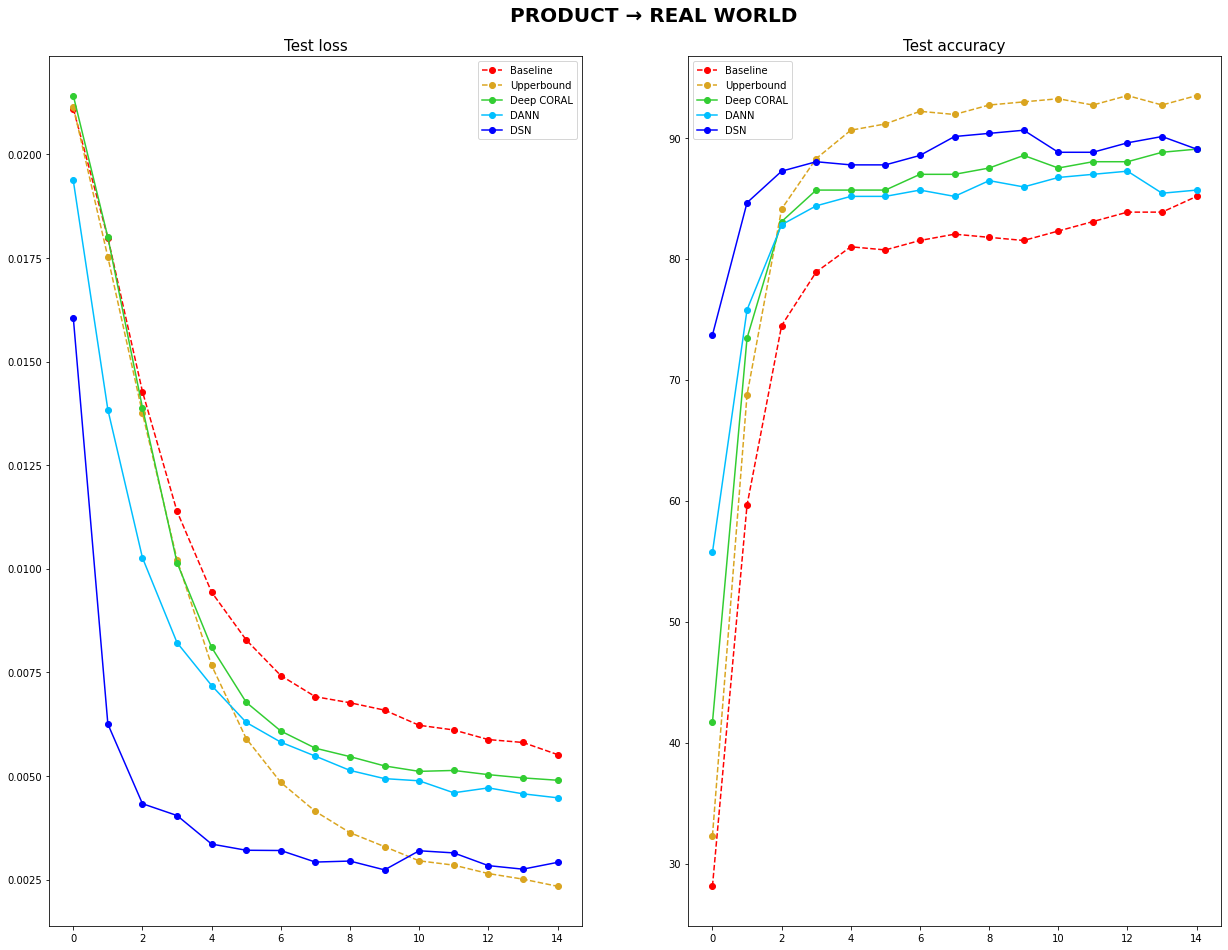

In [ ]:
get_validation_curve(source_path = PRODUCT_PATH)

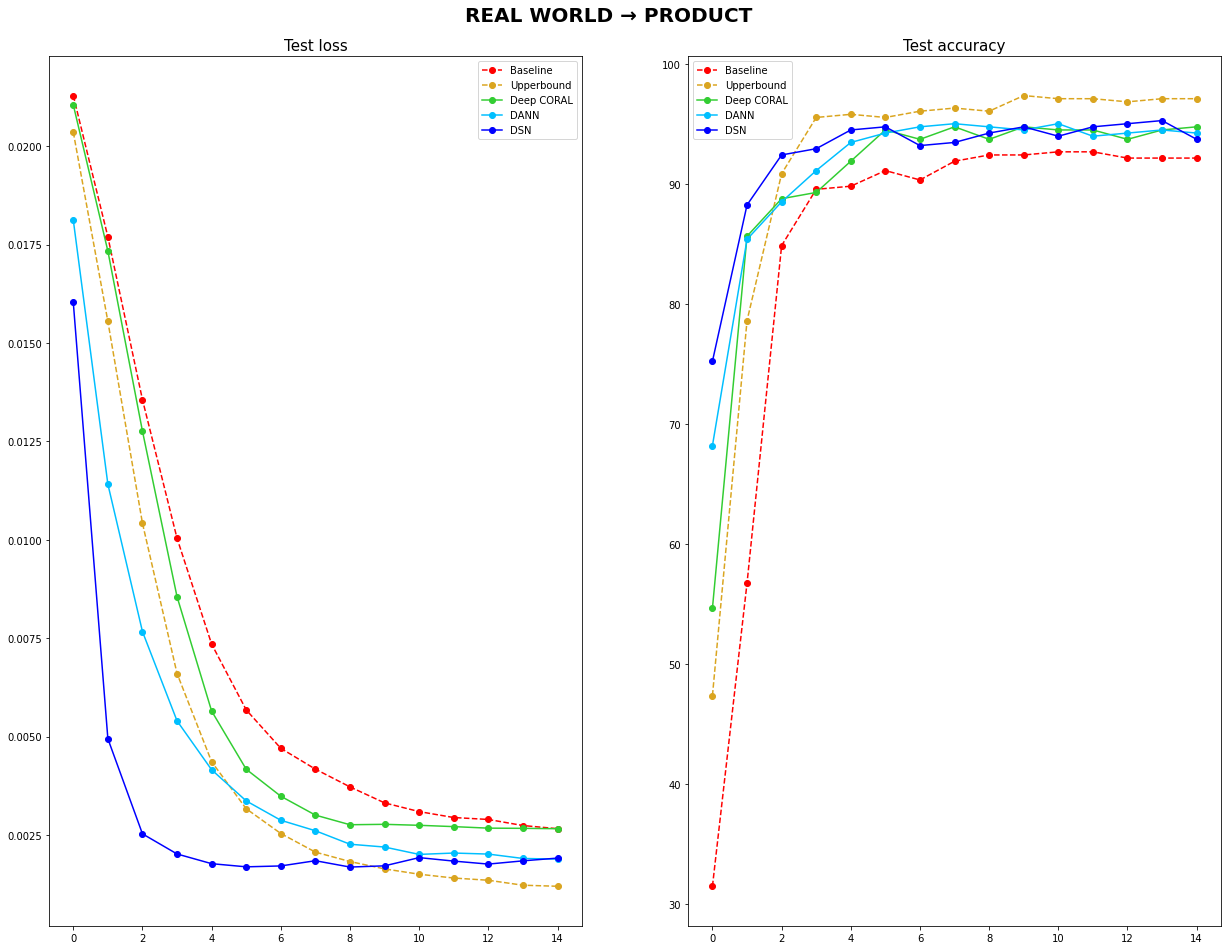

In [ ]:
get_validation_curve(source_path = REAL_PATH)

<p align = "justify"> As it holds for any standard UDA framework, the quality of the domain alignment strategy shall essentially be assessed by looking at the <b>gain</b> obtained with our proposed framework over the so called source-only baseline. <u>The more effective our chosen domain alignment strategy is, the higher our gain will be over the source-only version</u>. Our gain, therefore, will be defined as the difference between the accuracy of our full model and the accuracy of our source-only model and it is computed as follows:

$$Gain = acc_{uda} - acc_{so}$$

<p align = "justify"> Moreover, we computed also the Normalized Gain $G_{norm}$ over upperbound that is the difference between the UDA accuracy and the baseline normalized over the upperbound:
$$ G_{norm} = \frac{Gain}{acc_{ub} - acc_{so}}$$

<center><table>
  <tr>
    <td>
      <table>
        <caption><font size="4"><b><font color='black'>PRODUCT → REAL WORLD</caption>
        <tr>
          <th><center><font size="4"><font color='grey'>UDA model</th>
          <th><center><font size="4"><font color='grey'><i>acc<sub>uda</sub></th>
          <th><center><font size="4"><font color='grey'><i>acc<sub>so</sub></th>
          <th><center><font size="4"><font color='grey'><i>Gain</th>
          <th><center><font size="4"><font color='grey'><i>acc<sub>ub</sub></th>
          <th><center><font size="4"><font color='grey'><i>G<sub>norm</th>
        </tr>
        <tr>
          <td><center><font size="3"><font color='red'><b>Deep CORAL</td>
          <td><center><font size="3"><font color='goldenrod'><b>89.09%</td>
          <td><center><font size="3"><font color='limegreen'><b>83.85%</td>
          <td><center><font size="3"><font color='deepskyblue'><b>5.24%</td>
          <td><center><font size="3"><font color='blue'><b>92.71%</td>
          <td><center><font size="3"><font color='blueviolet'><b>0.59</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='red'><b>DANN</td>
          <td><center><font size="3"><font color='goldenrod'><b>85.16%</td>
          <td><center><font size="3"><font color='limegreen'><b>83.85%</td>
          <td><center><font size="3"><font color='deepskyblue'><b>1.31%</td>
          <td><center><font size="3"><font color='blue'><b>92.71%</td>
          <td><center><font size="3"><font color='blueviolet'><b>0.15</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='red'><b>DSN</td>
          <td><center><font size="3"><font color='goldenrod'><b>89.32%</td>
          <td><center><font size="3"><font color='limegreen'><b>83.85%</td>
          <td><center><font size="3"><font color='deepskyblue'><b>5.47%</td>
          <td><center><font size="3"><font color='blue'><b>92.71%</td>
          <td><center><font size="3"><font color='blueviolet'><b>0.62</td>
        </tr>
      </table>
    </td>
    <td>
      <table>
        <caption><font size="4"><b><font color='black'>REAL WORLD → PRODUCT</caption>
        <tr>
          <th><center><font size="4"><font color='grey'>UDA model</th>
          <th><center><font size="4"><font color='grey'><i>acc<sub>uda</sub></th>
          <th><center><font size="4"><font color='grey'><i>acc<sub>so</sub></th>
          <th><center><font size="4"><font color='grey'><i>Gain</th>
          <th><center><font size="4"><font color='grey'><i>acc<sub>ub</sub></th>
          <th><center><font size="4"><font color='grey'><i>G<sub>norm</th>
        <tr>
          <td><center><font size="3"><font color='red'><b>Deep CORAL</td>
          <td><center><font size="3"><font color='goldenrod'><b>94.53%</td>
          <td><center><font size="3"><font color='limegreen'><b>92.19%</td>
          <td><center><font size="3"><font color='deepskyblue'><b>2.34%</td>
          <td><center><font size="3"><font color='blue'><b>97.14%</td>
          <td><center><font size="3"><font color='blueviolet'><b>0.47</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='red'><b>DANN</td>
          <td><center><font size="3"><font color='goldenrod'><b>94.53%</td>
          <td><center><font size="3"><font color='limegreen'><b>92.19%</td>
          <td><center><font size="3"><font color='deepskyblue'><b>2.34%</td>
          <td><center><font size="3"><font color='blue'><b>97.14%</td>
          <td><center><font size="3"><font color='blueviolet'><b>0.47</td>
        </tr>
        <tr>
          <td><center><font size="3"><font color='red'><b>DSN</td>
          <td><center><font size="3"><font color='goldenrod'><b>94.01%</td>
          <td><center><font size="3"><font color='limegreen'><b>92.19%</td>
          <td><center><font size="3"><font color='deepskyblue'><b>1.82%</td>
          <td><center><font size="3"><font color='blue'><b>97.14%</td>
          <td><center><font size="3"><font color='blueviolet'><b>0.37</td>
        </tr>
      </table>
    </td>
  </tr>
</table>